# Predictive Web Analytics and Machine Learning of Mixed Datatypes

## Data Source: https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset

In [1]:
import numpy as np
import pandas as pd
import functools
import re
from concurrent.futures import ThreadPoolExecutor

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report

from scipy.stats import chi2_contingency
from kmodes.kprototypes import KPrototypes
import umap
import gower

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

#this is an overall switch, 
#set to true to show all plots interactively in notebook.
#set to false to hide all plots (they will still be saved to disk)
show=True

C:\Users\hanis\.conda\envs\MLDL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_table(df, figsize, loc='center', title=None, filename=None, show=True):
    """ 
    Convert pandas dataframe to a table image, plot and save it. 
    This is only a convenience to save a nicely formatted table to disk.
    
    Parameters:
    a. df (pandas dataframe): dataframe table.
    b. figsize (tuple): figure size to use in drawing the table.
    c. loc (string): one of the entries allowed for 'loc' variable in axes.table() to position the table.
    d. title (string): optional title for the table.
    e. filename (string): optional name of image file to save the table to.
    f. show (boolean): optional flag to plot the table to screen.
    
    Returns:
    None
    """
    cell_text = []
    for row in range(len(df)):
        cell_text.append(df.iloc[row])

    clr_1 = ['#ebf2f2']*df.shape[1]
    clr_2 = ['w']*df.shape[1]
    clrs = [clr_1, clr_2]*(df.shape[0]//2)
    if df.shape[0]%2!=0:
        clrs.append(clr_1)

    fig, ax = plt.subplots(figsize=figsize, squeeze=True)
    ax.axis('off')
    cols = df.columns.tolist()
    cols = ['\n'.join(re.findall('[A-Z][^A-Z]*', c)) for c in cols]
    tbl = ax.table(cellText=cell_text, colLabels=cols, cellLoc='center',loc=loc, cellColours=clrs)
    tbl.auto_set_column_width(col=list(range(len(df.columns))))
    
    if any([c.find('\n')!=-1 for c in cols]):
        cellDict = tbl.get_celld()
        for i in range(0,len(cols)):
            cellDict[(0,i)].set_height(0.2)
    
    if title is not None:
        ax.set_title('{}'.format(title.title()), loc='center')
    plt.tight_layout(pad=1)
    if filename is not None:
        plt.savefig(filename, format='png', dpi=fig.dpi, bbox_inches='tight')
    if show:
        plt.show();
    else:
        plt.close()

In [3]:
def multi_plot(df, cols, vars_type, title=None, filename=None, show=True):
    """ 
    Construct multiple plots of same type, plot and save them.
    
    Parameters:
    a. df (pandas dataframe): dataframe table.
    b. cols (list of strings, or list of list of string pairs): columns from df to plot. 
                list of string for univariate plots. list of list of string pairs for bivariate plots.
    c. vars_type (string): keyword either 'continuous' or 'categorical'
    d. title (string): optional title for the table.
    e. filename (string): optional name of image file to save to disk.
    f. show (boolean): optional flag to plot the figure to screen.
    
    Returns:
    None
    """
    num_plots = len(cols)
    num_cols = 6 if isinstance(cols[0],list) else 3
    num_cols = 1 if isinstance(cols[0],list) and cols[0]==['1','2'] else num_cols
    num_rows = (num_plots//num_cols) +(1 if num_plots%num_cols!=0 else 0)
    clrs = sns.color_palette('Set2')
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*3,num_rows*3))
        
    for (ix,col) in enumerate(cols):
        i = int(ix//num_cols)
        j = int(ix%num_cols)
        if vars_type=='continuous': #plot continuous variables
            if isinstance(cols[0],list)==False: #univariate distribution
                sns.histplot(data=df[col], color=clrs[ix], ax=axes[i,j])
                axes[i,j].set_xlabel(str(col), fontsize=10)
                axes[i,j].set_ylabel('')
                axes[i,j].set_ylim(top=900)
            else: #bivariate distribution
                sns.scatterplot(data=df, x=col[0], y=col[1], ax=axes[i,j])
                axes[i,j].set_xlabel(str(col[0]), fontsize=10)
                axes[i,j].set_ylabel(str(col[1]), rotation=90, fontsize=10)
            axes[i,j].set_xticks([])
            axes[i,j].set_yticks([])
        else: #plot categorical variables
            if isinstance(cols[0],list)==False: #univariate distribution
                sns.countplot(x=col, data=df, color=clrs[ix%len(clrs)], orient='v', stat='percent',
                              native_scale=True, ax=axes[i,j])
                axes[i,j].set_xlabel(str(col), fontsize=10)
                axes[i,j].tick_params(axis='both', labelsize=5, rotation=45)
            else: #bivariate distribution
                plt.close()
                fig, axes = plt.subplots(num_rows, num_cols, figsize=(8,8))
                sns.heatmap(df, cmap='viridis', annot=True, cbar=True, square=True, ax=axes, cbar_kws={'shrink': 0.8})

    for r in range(j+1,num_cols):
        axes[i,r].axis('off')
    
    if title is not None:
        plt.suptitle('{}'.format(title.title()), fontsize=10)
    plt.tight_layout(pad=1)
    if filename is not None:
        plt.savefig(filename, format='png', dpi=fig.dpi, bbox_inches='tight')
    if show:
        plt.show();
    else:
        plt.close()

In [4]:
def create_cramers_v_corr(df, varlst):
    '''
    This function calculates Cramer's V correlation score for each pair of categorical variables.
    
    Parameters:
    1. df (datafram): data
    2. varlst (list of lists): list of pairs of variables. The score is calculated for each pair
    
    Returns:
    df_cramers_v (dataframe): square dataframe with score for each pair of variables.
    '''
    var1 = []
    var2 = []
    cramers_v_lst = []
    for (v1, v2) in varlst:
        contingency_table = pd.crosstab(df[v1], df[v2]) # Create contingency table
        chi2, p, dof, ex = chi2_contingency(contingency_table) # Calculate Chi-square statistic

        # Calculate Cramér's V with bias correction
        n = contingency_table.sum().sum()
        k, r = contingency_table.shape
        phi2 = chi2 / n
        bias = (k-1)*(r-1) / (n-1)
        phi2_corrected = max(0, phi2 - bias)
        min_dim = min((k-1), (r-1))
        cramers_v = np.sqrt(phi2_corrected / min_dim)

        var1.append(v1)
        var2.append(v2)
        cramers_v_lst.append(cramers_v)

    df_cramers_v = pd.DataFrame({'Variable1': var1, 'Variable2':var2, 'Cramers_V':cramers_v_lst})
    df_cramers_v = df_cramers_v.pivot(index='Variable1', columns='Variable2', values='Cramers_V')
    df_cramers_v = df_cramers_v.combine_first(df_cramers_v.T) #to fill nans
    #to fill diagonal elements, there is no sense of correlation between variable and itself
    df_cramers_v = df_cramers_v.fillna(0) 

    return df_cramers_v

In [5]:
def sngl_plot(typ, data, x='', hue='', order=None, title=None, lbl_rot=0, filename=None, show=True):
    '''
    This is a convenience function to plot different plots used in EDA
    '''
    fig, ax = plt.subplots(figsize=(5,5))
    clrs = sns.color_palette('Set2')[:2][::-1]
    if title is not None:
        plt.title('{}'.format(title.title()))
    if typ=='bar':
        sns.barplot(x=x, y='percent', data=data, palette=clrs, hue=hue, order=order, legend='full', ax=ax)
    if typ=='cnt':
        if order is not None:
            clrs = sns.color_palette('Set2')[:3]
        sns.countplot(x=x, data=data, palette=clrs, hue=hue, order=order, dodge=False, stat='percent', legend='full',ax=ax)
    for container in ax.containers:
        ax.bar_label(container,labels=[f'{x:,.2f}%' for x in container.datavalues], label_type='center', rotation=lbl_rot)
    plt.tight_layout(pad=1)
    if filename is not None:
        plt.savefig(filename, format='png', dpi=fig.dpi, bbox_inches='tight')
    if show:
        plt.show();
    else:
        plt.close()

In [6]:
def preprocess(df):
    '''
    Function does the following:
    1. Feature Selection based on EDA findings:
       a. Reduce and rename 'ProductRelated' categories to the top 150 categories + 1 for the others.
       b. drop (ExitRates, Month, OperatingSystems, Browser)
    2. Maps the string values of 'VisitorType' to numeric values.
    3. splits df into (train and test sets) with stratification to maintiain class imbalance
    4. Transforms the training set numerical features to normal distribution, and applies the transform to the test sets.
    5. Calculate sample weight to handle class imbalance to be used in the training algorithm.
    '''
    #1:
    top_k = 150
    top_k_categories = df['ProductRelated'].value_counts().nlargest(top_k).index
    category_mapping = {category: i+1 for i, category in enumerate(top_k_categories)}
    category_mapping.update({category: 200 for category in df['ProductRelated'].unique() 
                             if category not in top_k_categories})
    df['ProductRelated'] = df['ProductRelated'].map(category_mapping)
    df['ProductRelated'] = df['ProductRelated'].to_frame().astype('category')
    
    df = df.drop(columns=['Month', 'ExitRates', 'OperatingSystems','Browser'])
    df['Weekend'] = df['Weekend'].to_frame().astype('category')
    
    #2:
    visitors = {'Returning_Visitor':2, 'New_Visitor':1, 'Other':0}
    df['VisitorType'] = df['VisitorType'].cat.rename_categories(visitors)
    
    #3:
    df_y = df['Revenue'].to_frame()
    df_x = df.drop(columns=['Revenue'])
    cats = [col for col in df.columns if df[col].dtype=="category"]
    conts = df_x.columns.difference(cats).tolist()
    df_x_trn, df_x_tst, df_y_trn, df_y_tst = train_test_split(df_x, df_y, test_size=0.2, random_state=42, stratify=df_y)
    
    #4:
    qt1 = QuantileTransformer(output_distribution='uniform')
    qt1.set_output(transform='pandas')
    trn = qt1.fit_transform(df_x_trn[conts])
    zero_mask = trn==0
    ntrn = trn[zero_mask]
    trn = trn[~zero_mask]
    qt2 = QuantileTransformer(output_distribution='normal')
    qt2.set_output(transform='pandas')
    trn = qt2.fit_transform(trn)
    trn = trn.fillna(2*trn.min(axis=0),axis=0)
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.set_output(transform='pandas')
    x_trn = scaler.fit_transform(trn)
    df_x_trn = pd.concat([x_trn, df_x_trn[cats]], axis=1)
    
    tst = qt1.transform(df_x_tst[conts])
    zero_mask = tst==0
    tst = tst[~zero_mask]
    tst = qt2.transform(tst)
    tst = tst.fillna(2*tst.min(axis=0),axis=0)
    x_tst = scaler.transform(tst)
    df_x_tst = pd.concat([tst,df_x_tst[cats]], axis=1)
    
    #5:
    sample_weight = df_y_trn.copy()
    sample_weight['value'] = sample_weight['Revenue'].map(df_y_trn['Revenue'].value_counts(normalize=True))
    sample_weight.drop(columns='Revenue',inplace=True)
    return df_x_trn, df_x_tst, df_y_trn, df_y_tst, sample_weight

In [7]:
def compare_categorical_strategy(X, y):
    '''
    This function compares handling categoricals in ML models, by validating following strategies:
    1. Simple dropping categorical variables and rely only on numerical variables.
    2. OneHot Encoding Categorical Variables
    3. Ordinal Encoding Categorical Variables
    4. Selecting Algorithm that can handle categorical variables natively without further processing.
    '''
    cats2 = ['Administrative', 'Informational', 'ProductRelated', 'Region', 'TrafficType', 'VisitorType', 'Weekend']
    scoring = "accuracy"
    n_cv_folds = 3
    X=df_x_trn
    y=df_y_trn.to_numpy().squeeze()

    #dropping categorical variables
    drop = make_column_transformer(("drop", make_column_selector(dtype_include="category")), remainder="passthrough")
    model_drop = make_pipeline(drop, HistGradientBoostingClassifier(random_state=42))

    #OneHot Encoding
    HEncoder = make_column_transformer((OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
                                        make_column_selector(dtype_include="category"),),remainder="passthrough",)
    model_1h = make_pipeline(HEncoder, HistGradientBoostingClassifier(random_state=42))

    #Ordinal Encoding
    OrdEncoder = make_column_transformer((OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
                                          make_column_selector(dtype_include="category"),),remainder="passthrough",
                                         verbose_feature_names_out=False)
    model_ordinal = make_pipeline(OrdEncoder, HistGradientBoostingClassifier(random_state=42))

    #Native, no Encodings
    model_native = HistGradientBoostingClassifier(random_state=42, categorical_features=cats2)

    results = [cross_validate(model_drop, X, y, cv=n_cv_folds, scoring=scoring), 
               cross_validate(model_1h, X, y, cv=n_cv_folds, scoring=scoring), 
               cross_validate(model_ordinal, X, y, cv=n_cv_folds, scoring=scoring), 
               cross_validate(model_native, X, y, cv=n_cv_folds, scoring=scoring)]
    return results

def compare_categorical_strategy_plot(results, scoring, ttl=None, filename=None, show=True):
    '''
    This function plots the results of cross validation of multiple models.
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))
    plot_info = [("fit_time", "Fit times (s)", ax1, None), ("test_score", scoring, ax2, None),]
    x, width = np.arange(4), 0.8
    
    for key, title, ax, y_limit in plot_info:
        items = [results[0][key], results[1][key], results[2][key], results[3][key]]
        loss_cv_mean = [np.mean(np.abs(item)) for item in items]
        loss_cv_std = [np.std(item) for item in items]
        ax.bar(x=x, height=loss_cv_mean, width=width, yerr=loss_cv_std, color=["C0", "C1", "C2", "C3"])
        ax.set(xlabel="Model", title=title, xticks=x, xticklabels=["Dropped", "One Hot", "Ordinal", "Native"],
               ylim=y_limit)
    
    if ttl is not None:
        plt.suptitle('{}'.format(ttl.title()), fontsize=10)
    plt.tight_layout(pad=1)
    if filename is not None:
        plt.savefig(filename, format='png', dpi=fig.dpi, bbox_inches='tight')
    if show:
        plt.show();
    else:
        plt.close()

In [8]:
def plot_multiple_heatmaps(model, dfx, dfy, weights, filename=None, show=True):
    '''
    This is a convenience function to plot multiple confusion matrices as heatmaps.
    '''
    num_plots = 4
    num_cols = 2
    num_rows = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*3,num_rows*3))
        
    for ix,(dfx, dfy, w) in enumerate(zip(dfx,dfy,weights)):
        i = int(ix//num_cols)
        j = int(ix%num_cols)
        if isinstance(w, int):
            w = None
        cm = pd.DataFrame(confusion_matrix(dfy, model.predict(dfx), sample_weight=w))
        sns.heatmap(cm, cmap='viridis', annot=True, fmt=".0f", cbar=True,square=True,ax=axes[i,j], cbar_kws={'shrink':0.8})
        cbar = axes[i,j].collections[0].colorbar
        cbar.set_ticks([])
        axes[i,j].set_xlabel('Predicted', fontsize=10)
        axes[i,j].set_ylabel('Actual', fontsize=10)
        title = ''
        if i==0:
            title += 'Train Data'
        else:
            title += 'Test Data'
        if j==1:
            title += ' + Class Imbalance'
        axes[i,j].set_title('{}'.format(title.title()), fontsize=10)
        
    for r in range(j+1,num_cols):
        axes[i,r].axis('off')

    plt.suptitle('Confusion Matrix', fontsize=10)
    plt.tight_layout(pad=1)
    if filename is not None:
        plt.savefig(filename, format='png', dpi=fig.dpi, bbox_inches='tight')
    if show:
        plt.show();
    else:
        plt.close()


def plot_multiple_tables(model, dfx, dfy, weights, filename=None, show=True):
    '''
    This is a convenience function to plot multiple classification reports.
    '''
    num_plots = 4
    num_cols = 2
    num_rows = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*4,num_rows*1.5))
        
    for ix,(df_x, df_y, w) in enumerate(zip(dfx,dfy,weights)):
        i = int(ix//num_cols)
        j = int(ix%num_cols)
        if isinstance(w, int):
            w = None
        df = (pd.DataFrame(classification_report(df_y, model.predict(df_x), 
                                                 output_dict=True, sample_weight=w))).T.reset_index()
        cell_text = []
        for row in range(len(df)):
            cell_text.append(df.iloc[row].apply(lambda x: f'{x:.2f}' if isinstance(x,str)==False else x))
        clr_1 = ['#ebf2f2']*df.shape[1]
        clr_2 = ['w']*df.shape[1]
        clrs = [clr_1, clr_2]*(df.shape[0]//2)
        if df.shape[0]%2!=0:
            clrs.append(clr_1)
        cols = df.columns.tolist()
        tbl = axes[i,j].table(cellText=cell_text, colLabels=cols, cellLoc='center',loc='center', cellColours=clrs)
        tbl.auto_set_column_width(col=list(range(len(df.columns))))
        
        title = ''
        if i==0:
            title += 'Train Data'
        else:
            title += 'Test Data'
        if j==1:
            title += ' + Class Imbalance'
        axes[i,j].set_title('{}'.format(title.title()), fontsize=10)
        axes[i,j].axis('off')
        
    for r in range(j+1,num_cols):
        axes[i,r].axis('off')

    plt.suptitle('Classification Report', fontsize=10)
    plt.tight_layout(pad=1)
    if filename is not None:
        plt.savefig(filename, format='png', dpi=fig.dpi, bbox_inches='tight')
    if show:
        plt.show();
    else:
        plt.close()

In [9]:
def kprototypes(data):
    '''
    This function is a callable from the kprototypes_threaded function to support parallelism.
    '''
    center, data, cats, sample_weight = data
    kproto = KPrototypes(n_clusters=center, init='random', random_state=42, n_jobs=-1)
    kproto.fit_predict(data, categorical=cats, sample_weight=sample_weight)
    return (center,kproto)

def kprototypes_threaded(df, sample_weight):
    '''
    Parallelize the execution of the KPrototypes algorithm since it is computationally expensive.
    Arguments:
    a. df (dataframe): dataframe containing the data to cluster on.
    b. sample_weight (numpy array): numpy array of length (df.shape[0],)
                                    This is the class imbalance of the target (Revenue) considering that
                                    the target is not part of the df passed.
    Returns:
    a. scores (list): cost computed by KPrototypes for each model (one model per number of clusters)
    b. models (list): KPrototypes models (one model per number of clusters)
    '''
    centers = list(range(1,df.shape[1]))
    scores = [0]*len(centers)
    cats = [df.columns.get_loc(col) for col in df.columns if df[col].dtype=="category"]
    data = df.to_numpy()
    models = [0]*len(centers)
    
    thread_data = iter([(i, data, cats, sample_weight) for i in centers])
    with ThreadPoolExecutor() as t:
        cntr_mdls = list(t.map(kprototypes,thread_data))
        
    for (center, model) in cntr_mdls:
        scores[center-1] = model.cost_
        models[center-1] = model
        
    return (scores, models)

def elbow(clusters, scores, title=None, filename=None, show=True):
    '''
    Elbow graph plot and save
    '''
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(clusters, scores, linestyle='--', marker='o', color='b');
    ax.set_xlabel('Clusters');
    ax.set_ylabel('Scores');
    if title is not None:
        plt.title('{}'.format(title.title()), fontsize=10)
    plt.tight_layout(pad=1)
    if filename is not None:
        plt.savefig(filename, format='png', dpi=fig.dpi, bbox_inches='tight')
    if show:
        plt.show();
    else:
        plt.close()

In [10]:
def plot_bar_table(df_lst, title=None, filename=None, show=True):
    '''
    This function takes a list of dataframes, and for each dataframe it plots a stacked bar graph
    and overlays a table of counts of each class in a stack over each row (cluster) in dataframe.
    '''
    num_plots = 3
    num_cols = 2
    num_rows = 2
    #clrs = sns.color_palette('Set2')
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*5,num_rows*5))

    for (ix,df) in enumerate(df_lst):
        i = int(ix//num_cols)
        j = int(ix%num_cols)
        
        df.plot(kind='bar',x='cluster', stacked=True, color=['red','green'], alpha=0.5, ax=axes[i,j], rot=0, legend=False)

        cell_text = []
        for row in range(len(df)):
            cell_text.append(df.iloc[row])
        clr_1 = ['#ebf2f2']*df.shape[1]
        clr_2 = ['w']*df.shape[1]
        clrs = [clr_1, clr_2]*(df.shape[0]//2)
        if df.shape[0]%2!=0:
            clrs.append(clr_1)
        tbl = axes[i,j].table(cellText=cell_text, colLabels=df.columns, cellLoc='center',loc='best', 
                              cellColours=clrs, colColours=['w','r','g'])
        tbl.auto_set_column_width(col=list(range(len(df.columns))))

        axes[i,j].set_xlabel('Cluster', fontsize=10)
        axes[i,j].set_ylabel('Count', rotation=90, fontsize=10)
        axes[i,j].set_yticks([])

    for r in range(j+1,num_cols):
        axes[i,r].axis('off')
    
    if title is not None:
        plt.suptitle('{}'.format(title.title()), fontsize=10)
    plt.tight_layout(pad=1)
    if filename is not None:
        plt.savefig(filename, format='png', dpi=fig.dpi, bbox_inches='tight')
    if show:
        plt.show();
    else:
        plt.close()

In [11]:
def UMAP_different_metrics(df):
    '''
    This function applies UMAP (Uniform Manifold Approximation & Projection) to project multidimensional data
    to 2 dimensions for later visualization. It is more generic than t-SNE since it can compute and plot according to
    different metrics; one metric for continuous values, and other metric for categorical variables.
    
    Parameters:
    df (dataframe): multidimensional data frame of both continuous and categorical variables
    
    Returns:
    embedding: UMAP 2D emedding according to the dissimilarity metric used (one for continuous, one for categorical)
    '''
    numerical = df.select_dtypes(exclude='category')
    categorical = df.select_dtypes(include='category')
    categorical = pd.get_dummies(categorical)

    #Percentage of columns which are categorical is used as weight parameter in embeddings later
    categorical_weight = len(df.select_dtypes(include='category').columns) / df.shape[1]

    #Embedding numerical & categorical
    fit1 = umap.UMAP(metric='l2').fit(numerical)
    fit2 = umap.UMAP(metric='dice').fit(categorical)

    #Create embedding on the intersection between the two metrics
    intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
    intersection = umap.umap_.reset_local_connectivity(intersection)
    embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                    fit1._initial_alpha, fit1._a, fit1._b, 
                                                    fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                    200, 'random', np.random, fit1.metric, 
                                                    fit1._metric_kwds, False,{},False)
    return embedding[0]

def UMAP_Gower_metric(df_x):
    '''
    This function applies UMAP (Uniform Manifold Approximation & Projection) to project multidimensional data
    to 2 dimensions for later visualization. This function uses the Gower metric which is suitable for computing
    dissimilarities among continuous variables and categorical variables.
    
    Parameters:
    df_x (dataframe): multidimensional data frame of both continuous and categorical variables
    
    Returns:
    embedding: UMAP 2D emedding according to the dissimilarity metric used (Gower metric)
    '''
    df = df_x.copy()
    cats = [c for c in df.columns.tolist() if df[c].dtype=="category"]
    df[cats] = df[cats].astype(str)
    gower_dist_matrix = gower.gower_matrix(df)
    reducer = umap.UMAP(metric='precomputed')
    embedding = reducer.fit_transform(gower_dist_matrix)
    return embedding

def UMAP_Plot(models, embedding, df_x, df_y, mode=None, filename=None, show=True):
    '''
    This function takes UMAP (Uniform Manifold Approximation & Projection) embedding,
    applies a number of clustering models to that embedding and plot the cluster distribution according to the
    embedding. Also it plots separately the participation of True/False revenues to the clusters.
    '''
    num_plots = 6
    num_cols = 2
    num_rows = 3

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*5,num_rows*5))
    revenue_color=['g' if e else 'r' for e in df_y['Revenue'].values.tolist()]
    r_patch = mpatches.Patch(color='red', label='False')
    g_patch = mpatches.Patch(color='green', label='True')

    for (ix,model) in enumerate(models):
        if mode=='train':
            clrs = model.labels_
        if mode=='test':
            cats_t = [df_x.columns.get_loc(col) for col in df_x.columns if df_x[col].dtype=="category"]
            clrs = model.predict(df_x.to_numpy(), cats_t).tolist()
        
        i = ix
        num_clusters = model.cluster_centroids_.shape[0]
        for j in range(2):
            if j==0:
                plot = axes[i,j].scatter(*embedding.T, s=22, c=clrs, cmap='tab20', alpha=0.5)
                axes[i,j].legend(*plot.legend_elements(), loc="best", title="Classes")
                axes[i,j].set_title('{} Cluster UMAP Representation'.format(num_clusters), loc='center')

            if j==1:
                plot = axes[i,j].scatter(*embedding.T, s=22, c=revenue_color, alpha=0.5)
                axes[i,j].legend(handles=[r_patch, g_patch], loc="best", title="Revenue")
                axes[i,j].set_title('Revenue Separation for {} Clusters'.format(num_clusters), loc='center')

    for r in range(j+1,num_cols):
        axes[i,r].axis('off')
    
    if mode is not None:
        plt.suptitle('{} Data'.format(mode.title()), fontsize=10)
    plt.tight_layout(pad=1)
    if filename is not None:
        plt.savefig(filename, format='png', dpi=fig.dpi, bbox_inches='tight')
    if show:
        plt.show();
    else:
        plt.close()

The data is obtained from https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset

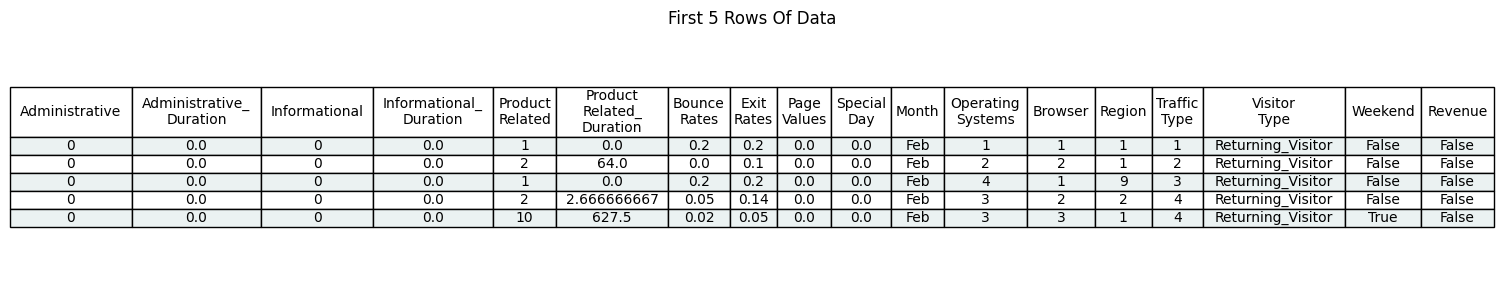

In [12]:
#load and display data
df = pd.read_csv('./Data/online_shoppers_intention.csv')
plot_table(df.head(),(15,3), title='first 5 rows of data', filename='table_01.png', show=show)

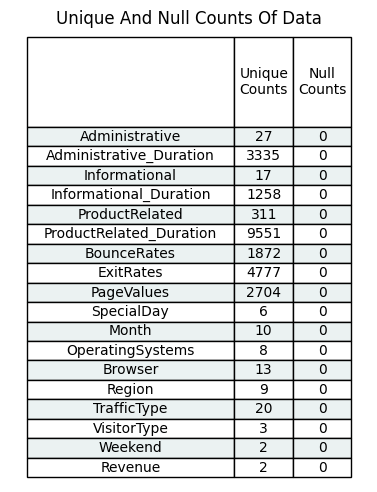

In [13]:
#Show "Unique Value Counts" and "Null Counts" for each column in data
unique_n_nulls = pd.merge(df.nunique().rename(index='UniqueCounts'),df.isnull().sum().rename(index='NullCounts'),
                          left_index=True, right_index=True).reset_index()

#Plotting
plot_table(unique_n_nulls,(4,5),title='Unique and Null Counts of data', filename='table_02.png',show=show)

In [14]:
#identify categorical variables
cats =['Administrative','Informational','ProductRelated', 'Month',
       'OperatingSystems', 'Browser','Region','TrafficType', 'VisitorType']

#identify bool variables
bools = ['Weekend','Revenue']

#identify continuous variables
conts = df.columns.difference(cats+bools).to_list()

#Let's create pairs of categorical variables and continuous variables to check bivariate distributions later.
bi_cats, bi_conts = [], []
cats1 = cats.copy()
cats1.extend(bools)
bi_vars = [bi_cats, bi_conts]
for (i,s) in enumerate([cats1,conts]):
    ss = [{x,y} for x in s for y in s if x!=y]
    bi_vars[i] = functools.reduce(lambda l, x: l.append(x) or l if x not in l else l, ss, [])
    bi_vars[i] = [list(j) for j in bi_vars[i]]
bi_cats, bi_conts = bi_vars[0], bi_vars[1]

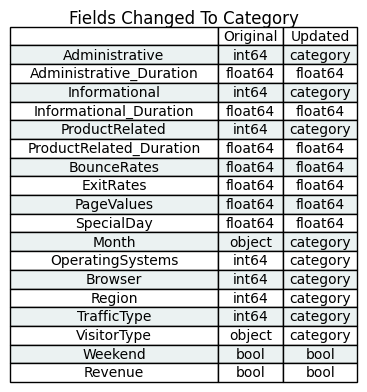

In [15]:
#show variable types and update variables that may be regarded as continuous (e.g. ints, floats) to be categorical.
org = df.dtypes.rename(index='Original',inplace=True)
df[cats] = df[cats].astype('category')
updt = df.dtypes.rename(index='Updated',inplace=True)

df_types = pd.merge(org,updt,left_index=True,right_index=True).reset_index()

#plotting
plot_table(df_types,(4,4),title='Fields changed to category', filename='table_03.png',show=show)

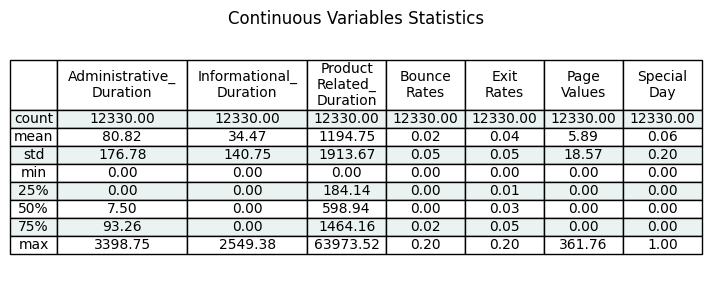

In [16]:
#show basic statistics about data
df_stats = df.describe()

#plotting
for col in df_stats.columns:
    df_stats[col] = df_stats[col].apply(lambda x: '{:.2f}'.format(x))
df_stats = df_stats.reset_index()
plot_table(df_stats,(5,3), title='Continuous variables statistics', filename='table_04.png',show=show)

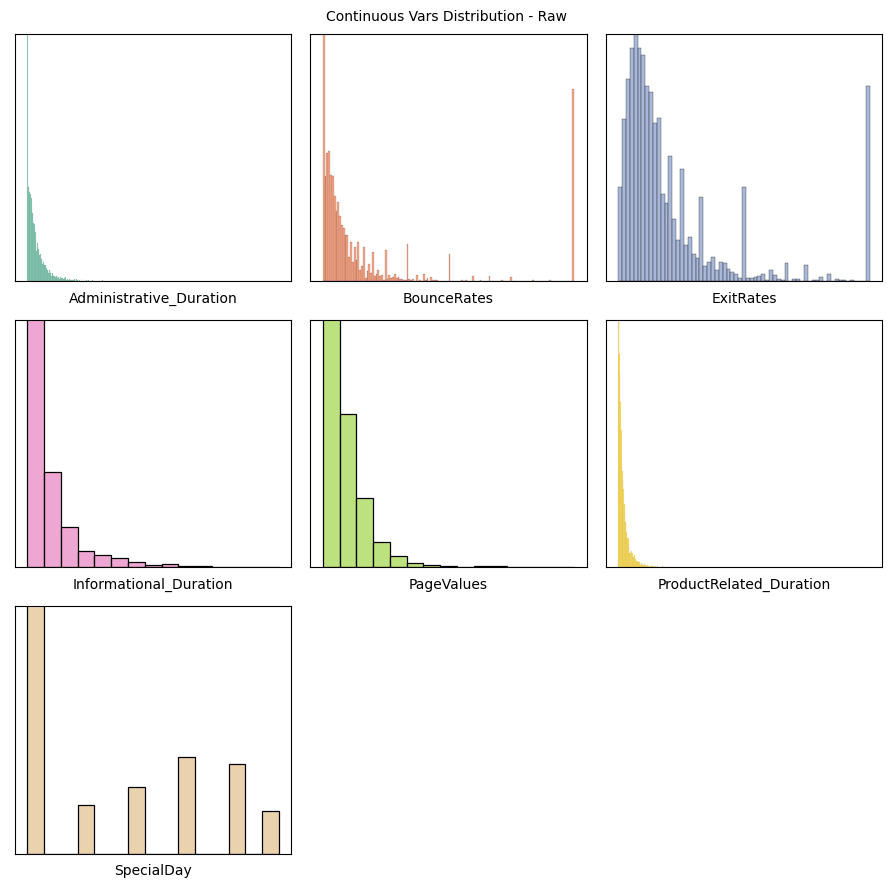

In [17]:
#let's see the univariate distributions of the continuous variables:
#Preparing Data
df_tmp = df.drop(columns=cats+bools)

#plotting
multi_plot(df_tmp, conts, 'continuous', title='Continuous Vars Distribution - Raw', filename='fig_01.png', show=show)

#All histograms show heavy right skewness
#Findings:
#1. Minimal Admin_Duration, Informational_Duration occurs most often, which is a healthy sign of 
#   a good design focusing the user experience on Product_Duration
#2. Page Values distribution suggest that a limited amount of pages have significant occurance. This suggests that either:
#2.a pages design must be revisited to distribute user experience over more pages or;
#2.b The valuation procedure for the pages to be revisited as it tends provide the least values to the most occurences.

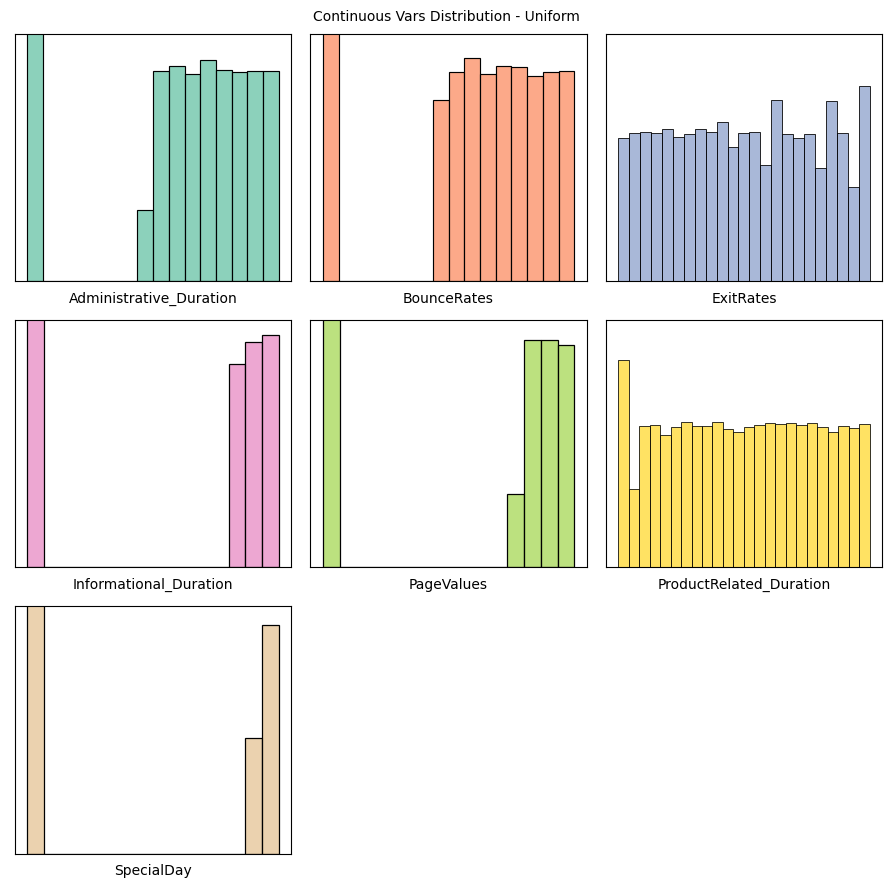

In [18]:
# ok so data is heavily skewed, which will probably impact the quality of any further learning algorithms.
# let's transform the data into a more manageable distribution.

qt1 = QuantileTransformer(output_distribution='uniform')
qt1.set_output(transform='pandas')
df_tmp = df.drop(columns=cats+bools)
df_tmp[conts] = qt1.fit_transform(df_tmp[conts])

#plotting
multi_plot(df_tmp, conts, 'continuous', title='Continuous Vars Distribution - Uniform', filename='fig_02.png', show=show)

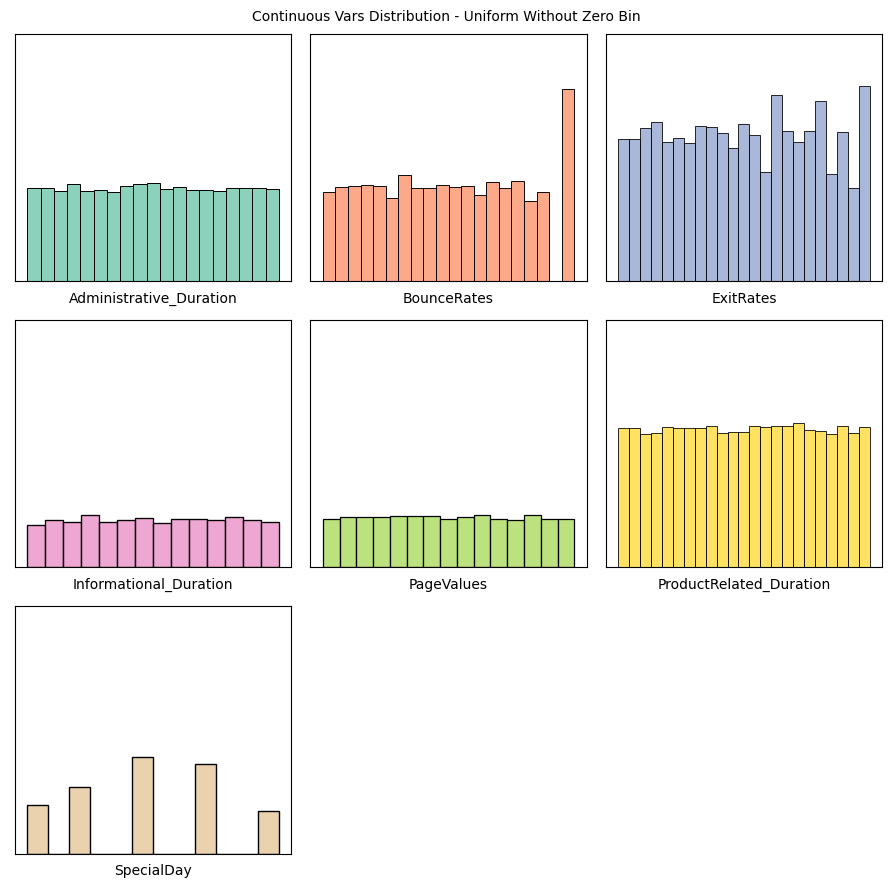

In [19]:
#ok, we have good uniform transformation, but with a big gap between the bins and the bin at 0.
#let's drop this zero bin
zero_mask = df_tmp[conts]==0
df_tmp = df_tmp[~zero_mask]

#plotting
multi_plot(df_tmp, conts, 'continuous', title='Continuous Vars Distribution - Uniform without Zero bin',
           filename='fig_03.png', show=show)

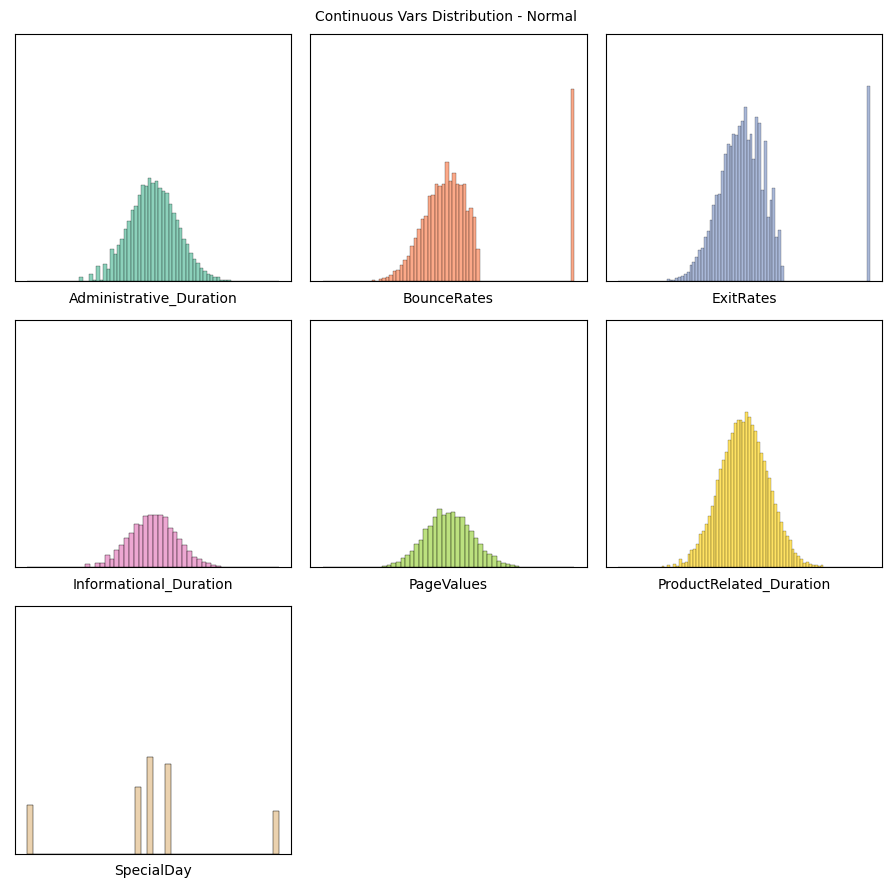

In [20]:
#ok much better. Let's try to transform it further to normal distribution
qt2 = QuantileTransformer(output_distribution='normal')
qt2.set_output(transform='pandas')
df_tmp[conts] = qt2.fit_transform(df_tmp[conts])

#plotting
multi_plot(df_tmp, conts, 'continuous', title='Continuous Vars Distribution - Normal', filename='fig_04.png', show=show)

#This we can work with. But let's check correlations.

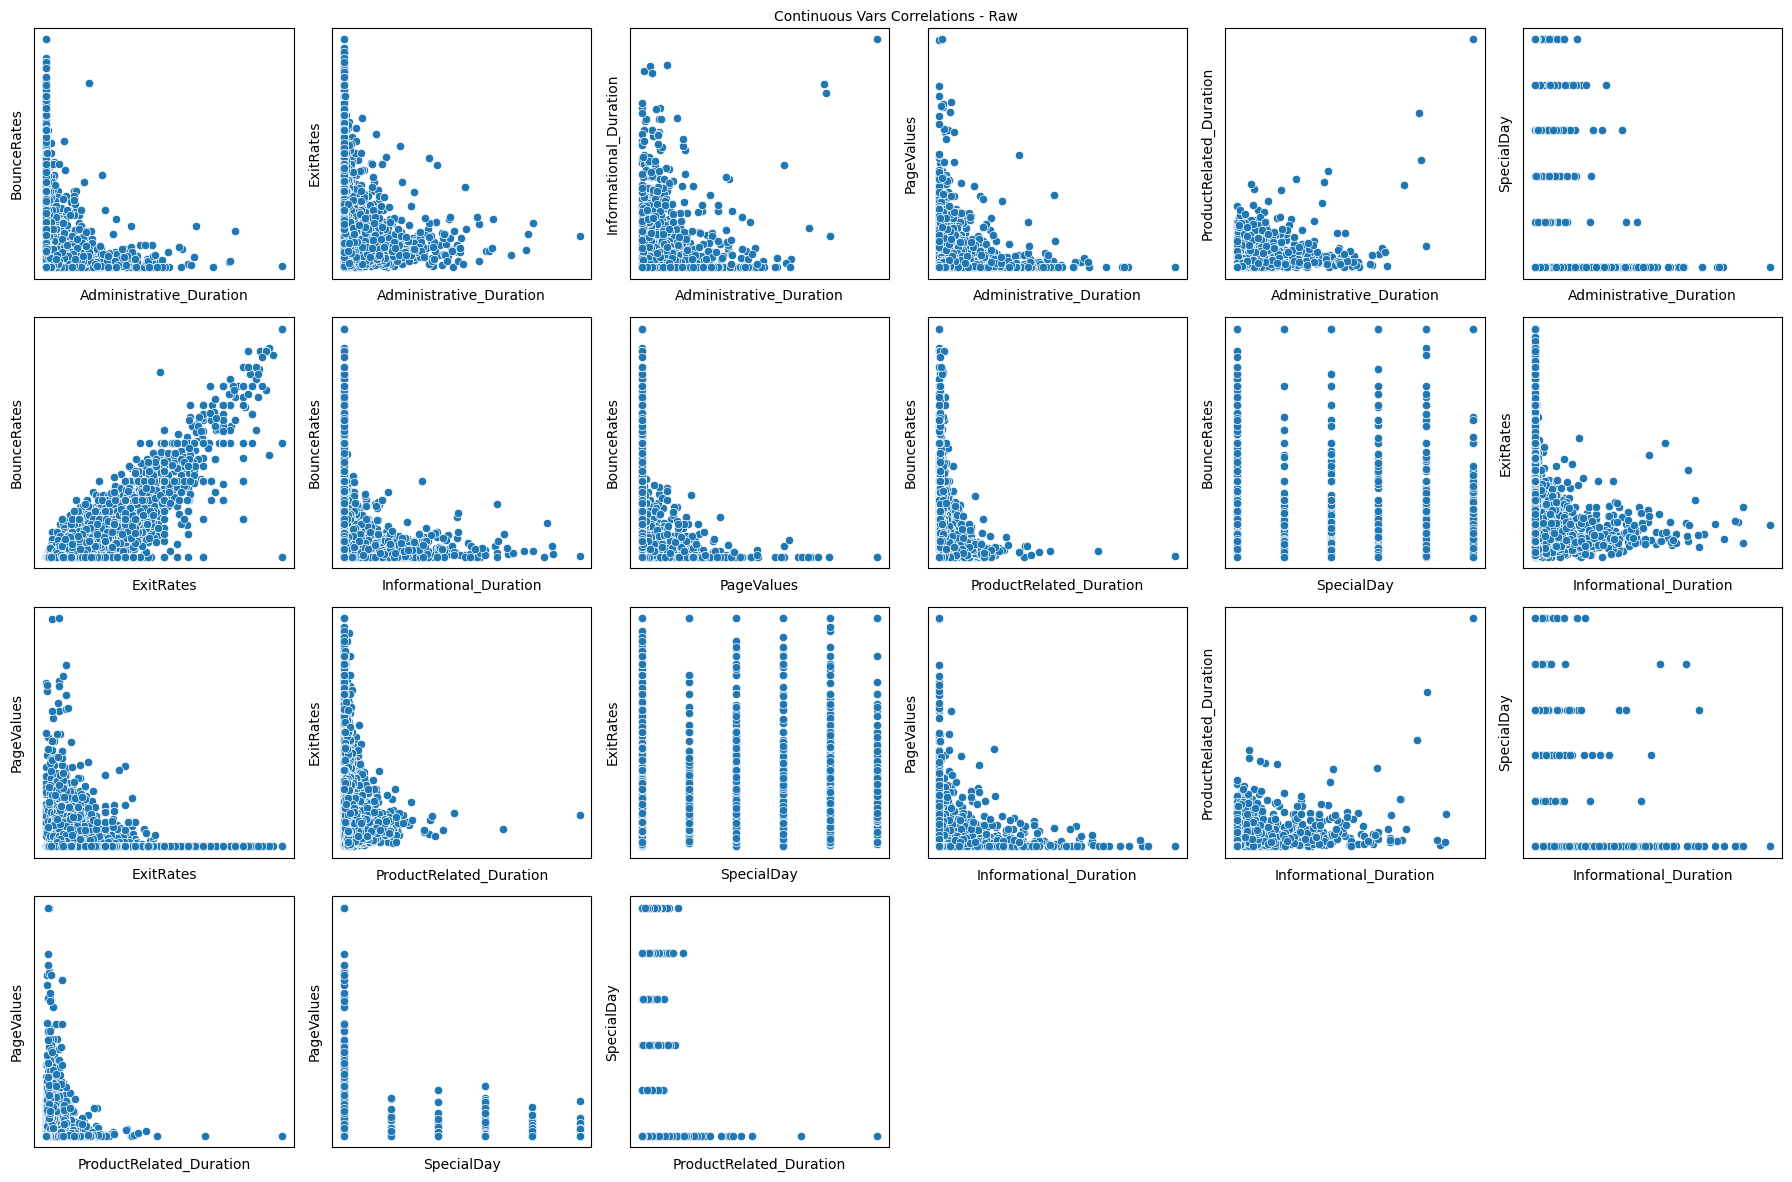

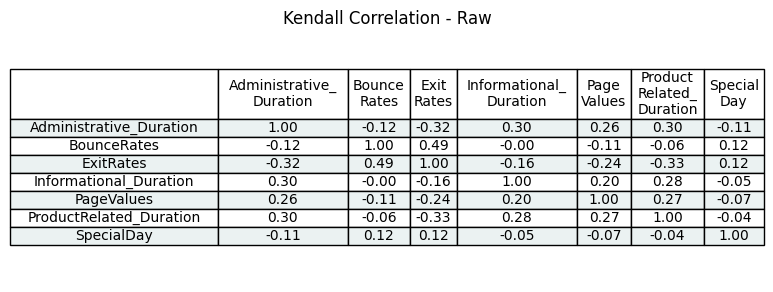

In [21]:
#let's see the bivariate distributions of the continuous variables:
#Preparing Data
df_corr = df[conts].corr(method='kendall')
for col in df_corr.columns:
    df_corr[col] = df_corr[col].apply(lambda x: '{:.2f}'.format(x))

#plotting
multi_plot(df[conts], bi_conts, 'continuous', title='Continuous Vars Correlations - Raw', filename='fig_05.png', show=show)
#BounceRates and Exist Rates are positive correlated. All others have severe right skewness.

#Let's check the correlation between variables
plot_table(df_corr.reset_index(), (8,3), title='Kendall correlation - Raw', filename='table_05.png',show=show)

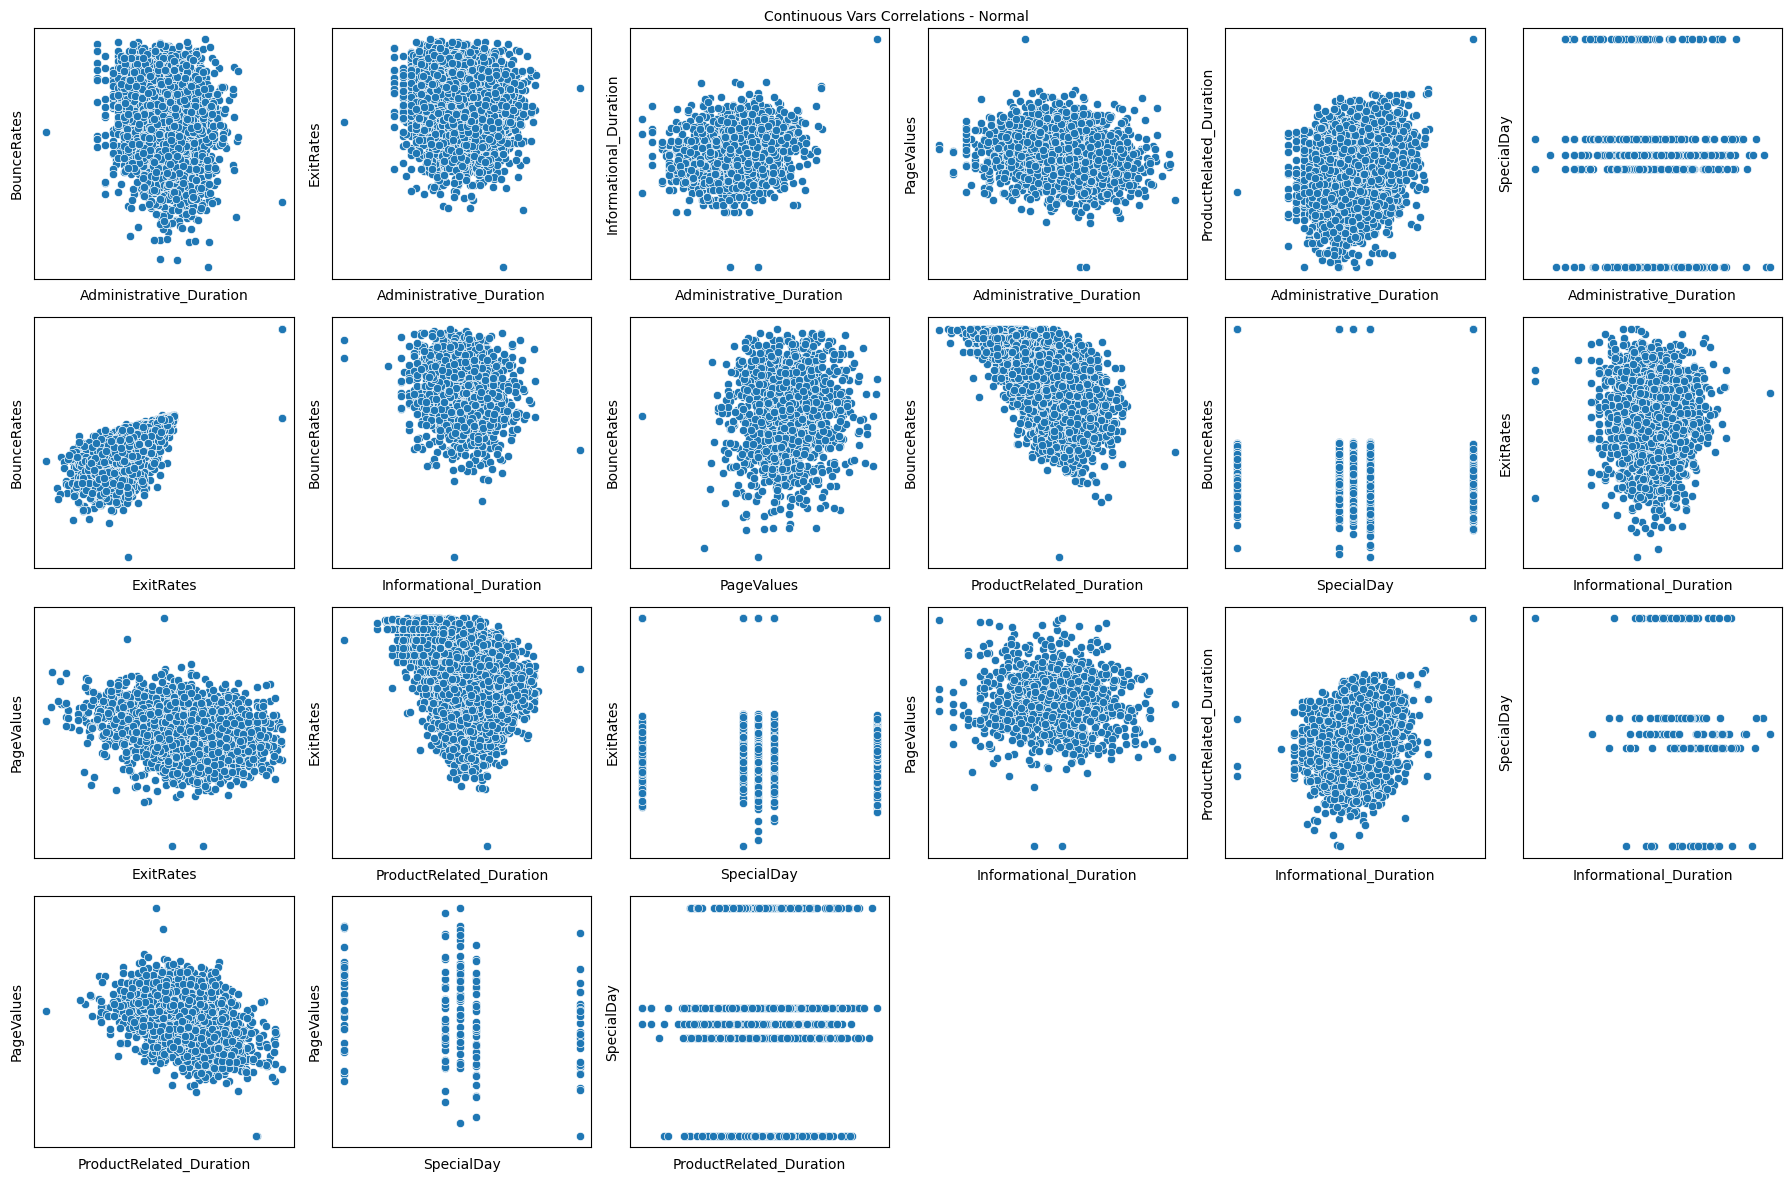

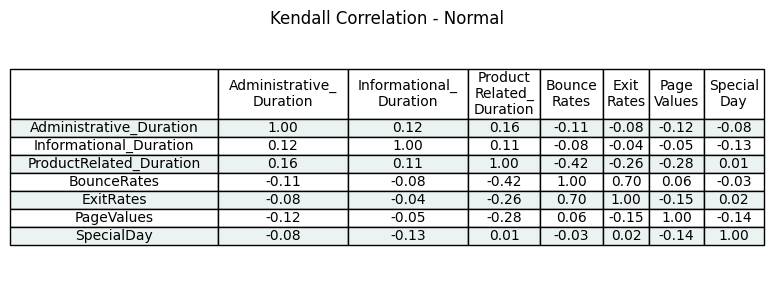

In [22]:
#let's see the bivariate distributions of the continuous variables:
#Preparing Data
df_corr = df_tmp.corr(method='kendall')
for col in df_corr.columns:
    df_corr[col] = df_corr[col].apply(lambda x: '{:.2f}'.format(x))

#plotting
multi_plot(df_tmp, bi_conts, 'continuous', title='Continuous Vars Correlations - Normal', filename='fig_06.png', show=show)
#BounceRates and Exist Rates are positive correlated. All others have severe right skewness.

#Let's check the correlation between variables
plot_table(df_corr.reset_index(), (8,3), title='Kendall correlation - Normal', filename='table_06.png',show=show)

#much better. Almost no corellations now except for BounceRates and ExitRates which are even magnified.
#We can use one of them only in our learning algorithms.

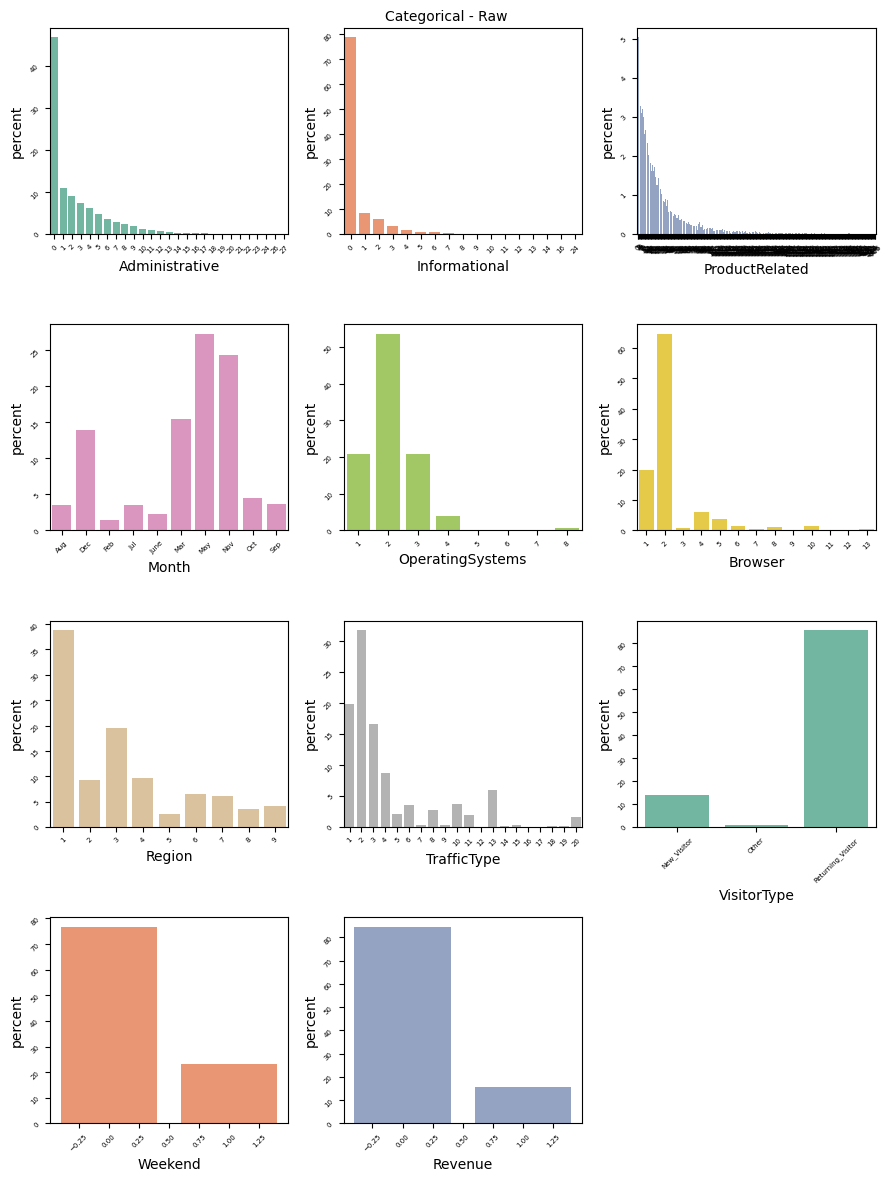

In [23]:
#Let's see the univariate distributions of the categorical and boolean variables:
df_tmp = df.drop(columns=conts)

#plotting
multi_plot(df_tmp, cats+bools, 'categorical', title='Categorical - Raw', filename='fig_07.png', show=show)

#Findings:
#1. Revenue as target variable has huge class imbalance.
#2. Administrative, Informational, Product Related all seem to be of continuous nature; though they are pages.
#   This indicate that there are pages that are rarely visited.

In [24]:
#specially for 'ProductRelated', we indicated earlier that there are 311 different levels. This could be problematic
#downstream when we build ML models. We see that with a dataset of 12330 records, top 150 category levels cover 12047
#records. This means that the remaining ~300 records are distributed on another 160 levels, on an average of less than
#2 records per category. During preprocessing for ML models, we will rename the top 150 levels to be from 1 to 150, and
#lump the other levels into one category; we will call it level 200
df['ProductRelated'].value_counts().nlargest(150).sum()

12047

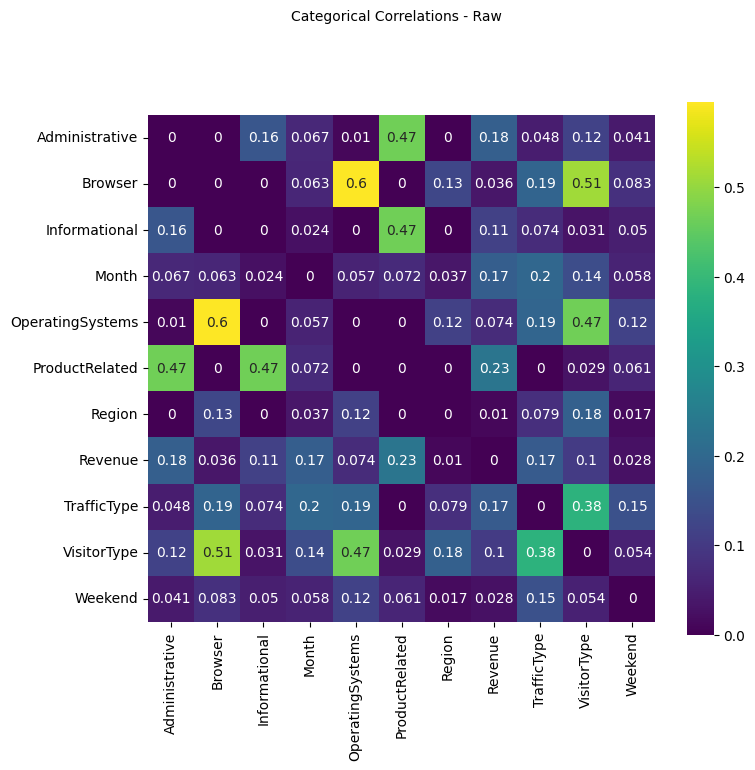

In [25]:
#preparing data
df_crmrs_v = create_cramers_v_corr(df, bi_cats)

#plotting
multi_plot(df_crmrs_v,[['1','2']], 'categorical', title='Categorical Correlations - Raw', filename='fig_08.png', show=show)

#we see high correlation between:
#1. Browser, OperatingSystems (0.6)
#2. Browser, VisitorType (0.51)
#3. OperatingSystems, VisitorType (0.47)
#4. Administrative, Product Related (0.47)
#5. Informational, Product Related (0.47)
#6. TrafficType, VisitorType (0.38)
# A General Guideline (need ref) that Cramer's V above 0.7 can result in multicolinearity.
# As we see that Browser, OperatingSystems are not main variables in our task, we will drop them. Which will drop
# the highest 3 Cramer's V.

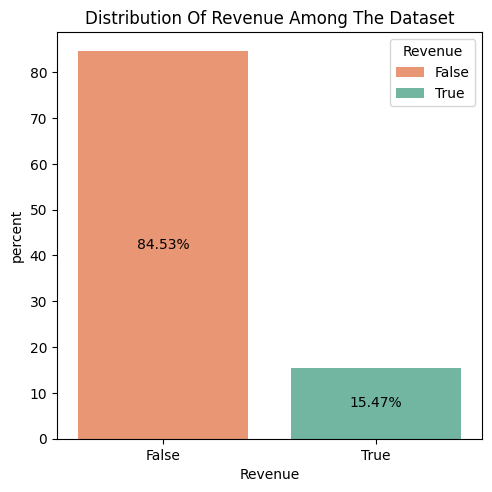

In [26]:
#plotting
ttl = 'Distribution of Revenue Among the DataSet'
sngl_plot('cnt', df, x='Revenue', hue='Revenue', order=None, title=ttl, lbl_rot=0, filename='fig_09.png', show=show)

# This is very important finding -- huge class imbalance

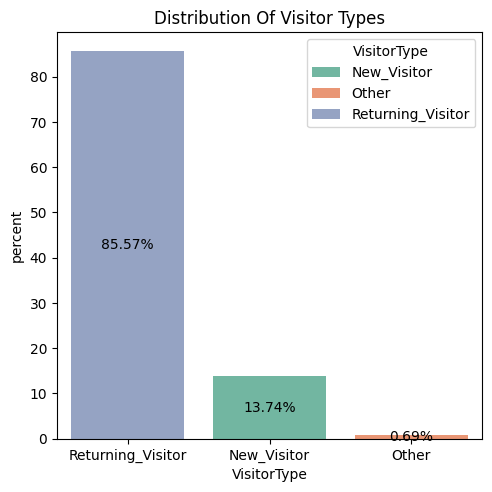

In [27]:
#plotting
ordr=['Returning_Visitor','New_Visitor','Other']
ttl = 'Distribution of Visitor Types'
sngl_plot('cnt', df, x='VisitorType', hue='VisitorType',order=ordr,title=ttl, lbl_rot=0, filename='fig_10.png', show=show)

#Not clear what is the "Other" entry.
#We have returning visitors, but revenue is substantially false!

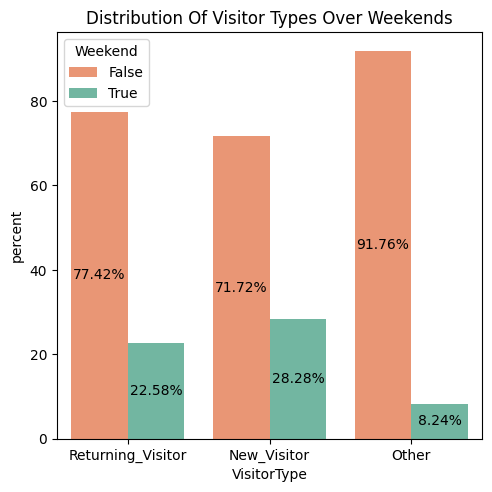

In [28]:
#preparing data
df1 = df.groupby('VisitorType')['Weekend'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

#plotting
ordr=['Returning_Visitor','New_Visitor','Other']
ttl = 'Distribution of Visitor Types over Weekends'
sngl_plot('bar', df1, x='VisitorType', hue='Weekend',order=ordr,title=ttl, lbl_rot=0, filename='fig_11.png', show=show)


#The 'Other' entry has a wildly disparate behavior

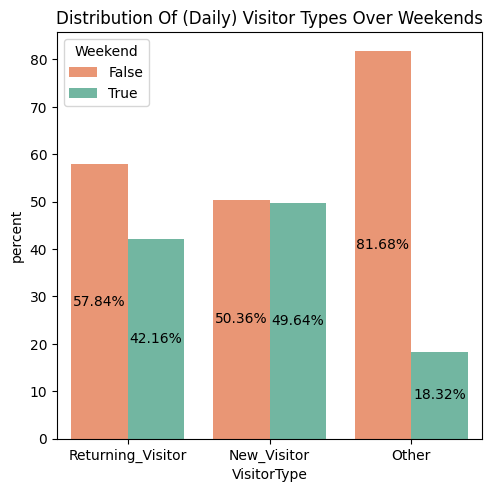

In [29]:
# The above is normal variation, since weekend is 2 days only and weekdays are 5 days.
# Let's see what happens if we check the average daily visit during weekdays and weekends.

#counts of each group identified by visitor type, and weekend
df1 = df.groupby('VisitorType')['Weekend'].value_counts().rename('count').reset_index() 

# divide the counts by 5 for weekdays, and by 2 for weekends to get daily count of visits by group
conditions = [df1['Weekend'].eq(True),df1['Weekend'].eq(False)]
choices = [df1['count'].div(2),df1['count'].div(5)]
df1['count'] = np.select(conditions,choices)

#convert the counts of each group to percentage
df1['count'] = (df1['count']/df1.groupby('VisitorType')['count'].transform('sum')).mul(100)
df1.rename(columns={'count':'percent'}, inplace=True)

#plotting
ordr=['Returning_Visitor','New_Visitor','Other']
ttl = 'Distribution of (DAILY) Visitor Types over Weekends'
sngl_plot('bar', df1, x='VisitorType', hue='Weekend', order=ordr, title=ttl, lbl_rot=0, filename='fig_12.png', show=show)

#still the 'Other' category has a wildly disparate behavior

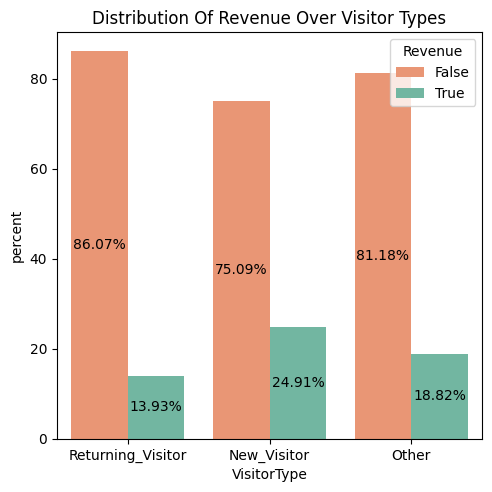

In [30]:
#Preparing Data
df1 = df.groupby('VisitorType')['Revenue'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

#plotting
ordr=['Returning_Visitor','New_Visitor','Other']
ttl = 'Distribution of Revenue over Visitor Types'
sngl_plot('bar', df1, x='VisitorType', hue='Revenue', order=ordr, title=ttl, lbl_rot=0, filename='fig_13.png', show=show)

#returning visitors participation in false revenue is greater than new visitors. Why do they return?

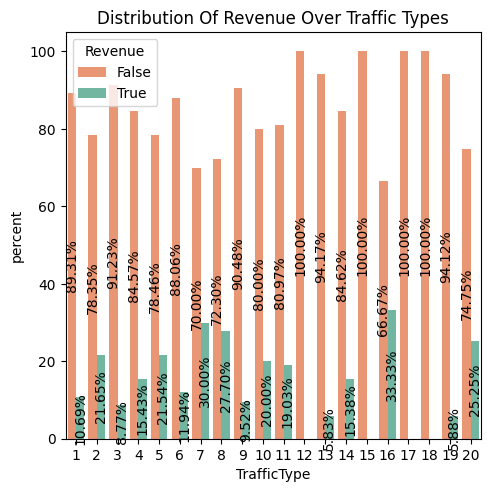

In [31]:
#Preparing Data
df1 = df.groupby('TrafficType')['Revenue'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

#plotting

ttl = 'Distribution of Revenue over Traffic Types'
sngl_plot('bar', df1, x='TrafficType', hue='Revenue', order=None, title=ttl, lbl_rot=90, filename='fig_14.png', show=show)

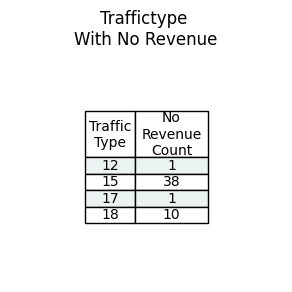

In [32]:
#Preparing Data
df1=df.groupby('TrafficType')['Revenue'].value_counts().rename('NoRevenueCount').reset_index()
ix=(df1.groupby('TrafficType')['Revenue'].count()==1)
ix=ix[ix.values==(True)]
df1 = df1[df1['TrafficType'].isin(ix.index)].drop(columns='Revenue')

#Plotting
plot_table(df1, (3,3), title='TrafficType \nwith No Revenue', filename='table_07.png',show=show)

#Those Traffic Types (12, 15, 17, 18) DONOT result in any revenue.

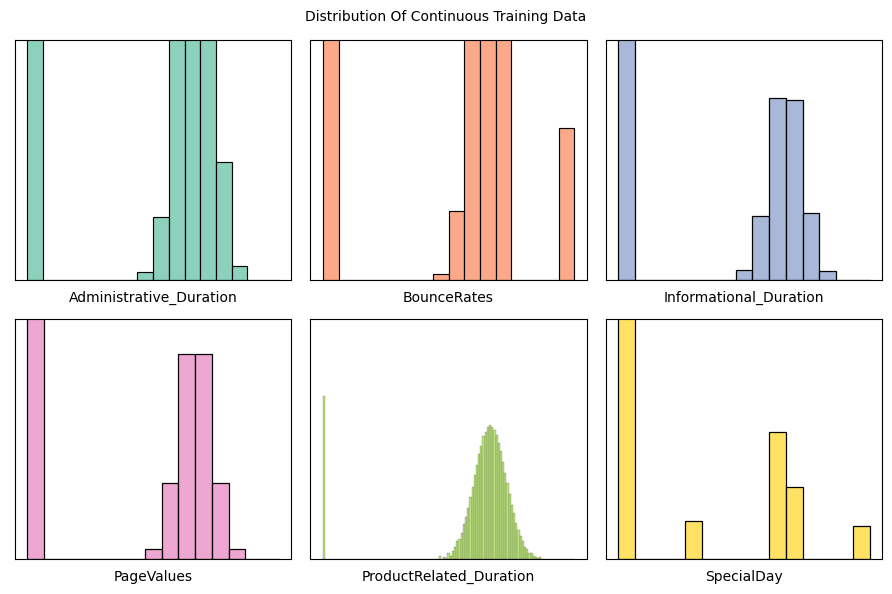

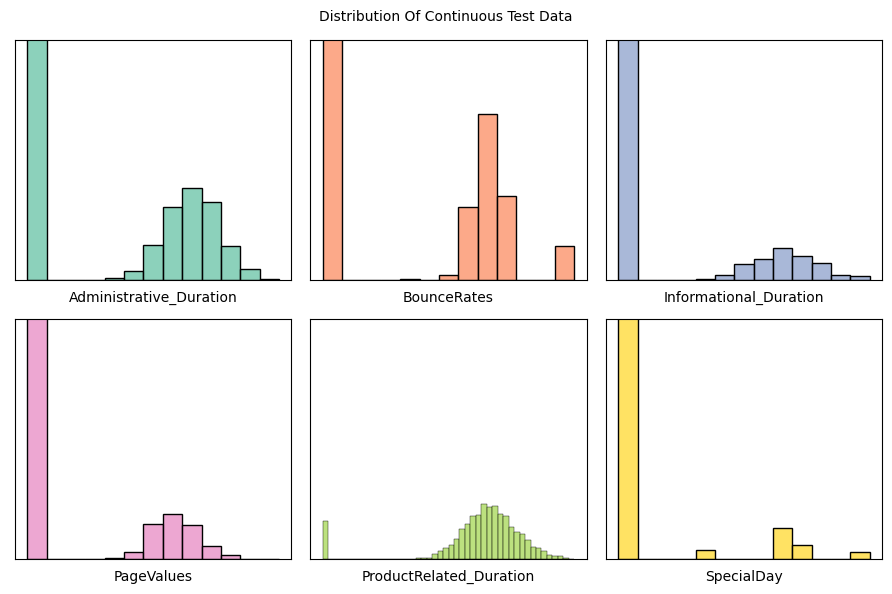

In [33]:
#preparing data
df_x_trn, df_x_tst, df_y_trn, df_y_tst, sample_weight = preprocess(df)

#plotting
c=conts.copy()
c.remove('ExitRates')
multi_plot(df_x_trn, c, 'continuous', title='Distribution of Continuous Training Data', filename='fig_15.png', show=show)
multi_plot(df_x_tst, c, 'continuous', title='Distribution of Continuous Test Data', filename='fig_16.png', show=show)

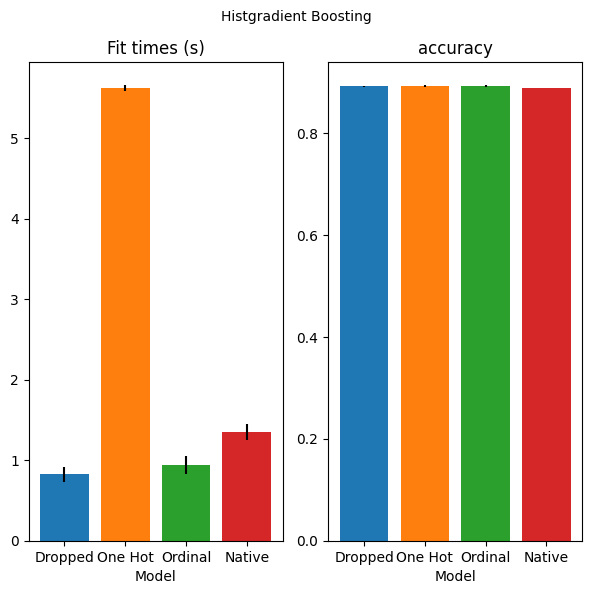

In [34]:
#preparing data
results = compare_categorical_strategy(df_x_trn, df_y_trn.to_numpy().squeeze())

#plotting
compare_categorical_strategy_plot(results, 'accuracy', ttl="HistGradient Boosting", filename='fig_17.png',show=show)

#1. Dropping is very naive approach. We loose lot of data.
#2. OneHot is good, but extremely expensive in terms of computing time.
#3. Ordinal encoding is good, but we cannot know if the model infered any unintended order for the categorical variables.
#4. Native is the best to use, reasonable execution time, and slight loss in accuracy.

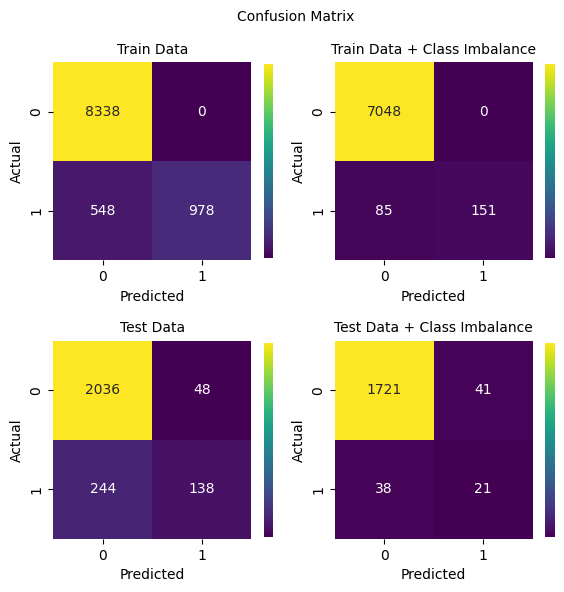

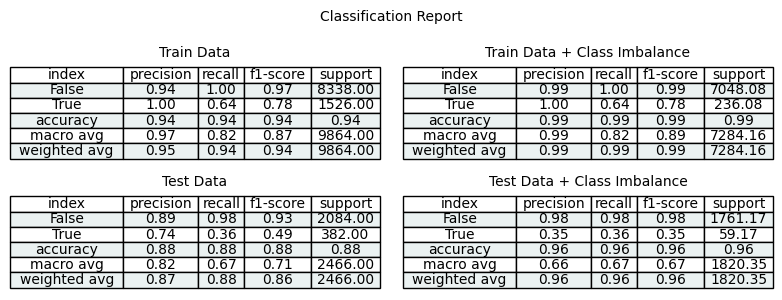

In [35]:
#preparing data
trn_weights = df_y_trn.copy()
trn_weights['value'] = trn_weights['Revenue'].map(df_y_trn['Revenue'].value_counts(normalize=True))
trn_weights.drop(columns='Revenue',inplace=True)
trn_weights=trn_weights.to_numpy().squeeze()

tst_weights = df_y_tst.copy()
tst_weights['value'] = tst_weights['Revenue'].map(df_y_tst['Revenue'].value_counts(normalize=True))
tst_weights.drop(columns='Revenue',inplace=True)
tst_weights=tst_weights.to_numpy().squeeze()

dfx = [df_x_trn, df_x_trn, df_x_tst, df_x_tst]
dfy = [df_y_trn, df_y_trn, df_y_tst, df_y_tst]
weights = [1, trn_weights, 1, tst_weights]

cats = ['Administrative', 'Informational', 'ProductRelated', 'Region', 'TrafficType', 'VisitorType', 'Weekend']
model = HistGradientBoostingClassifier(random_state=42, categorical_features=cats, l2_regularization=0.05, 
                                       class_weight={0:0.8453, 1:0.1547})
model.fit(df_x_trn, df_y_trn.to_numpy().squeeze())


#plotting
plot_multiple_heatmaps(model, dfx, dfy, weights, filename='fig_18.png', show=show)
plot_multiple_tables(model, dfx, dfy, weights, filename='table_08.png', show=show)

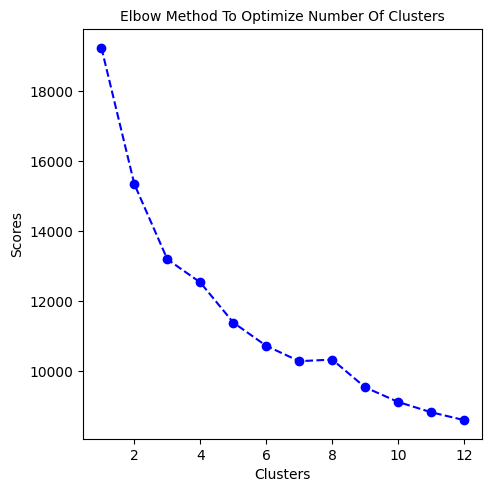

In [36]:
#Running KProtoTypes
#preparing data
scores, models = kprototypes_threaded(df_x_trn, sample_weight.to_numpy().squeeze())
clusters = [m.cluster_centroids_.shape[0] for m in models]

#plotting
elbow(clusters, scores, title='Elbow Method to Optimize Number of Clusters', filename='fig_19.png', show=show)

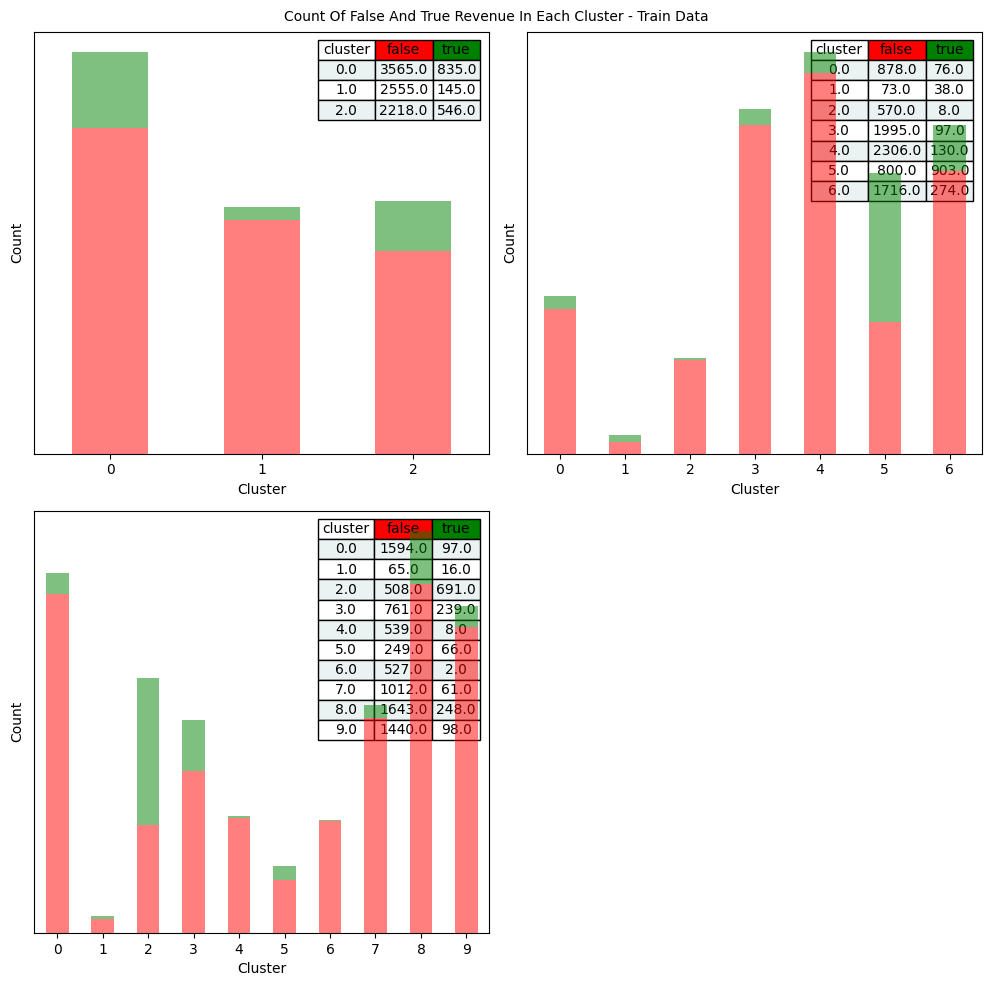

In [37]:
#preparing data
best_models = [models[2],models[6], models[9]]
cols = ['cluster','false','true']
df_tmp = []
for m in best_models:
    df_stk = pd.DataFrame({'cluster': m.labels_, 'revenue':df_y_trn['Revenue'].tolist()})
    df_stk = df_stk.groupby('cluster')['revenue'].value_counts().rename('count').to_frame().unstack().reset_index()
    df_stk.columns = df_stk.columns.to_flat_index()
    cols_dict = {df_stk.columns[i]:cols[i] for i in range(len(cols))}
    df_stk = df_stk.rename(columns=cols_dict)
    df_tmp.append(df_stk)

#plotting
ttl='Count of false and true Revenue in each cluster - Train Data'
plot_bar_table(df_tmp, title=ttl, filename='fig_20.png',show=show)

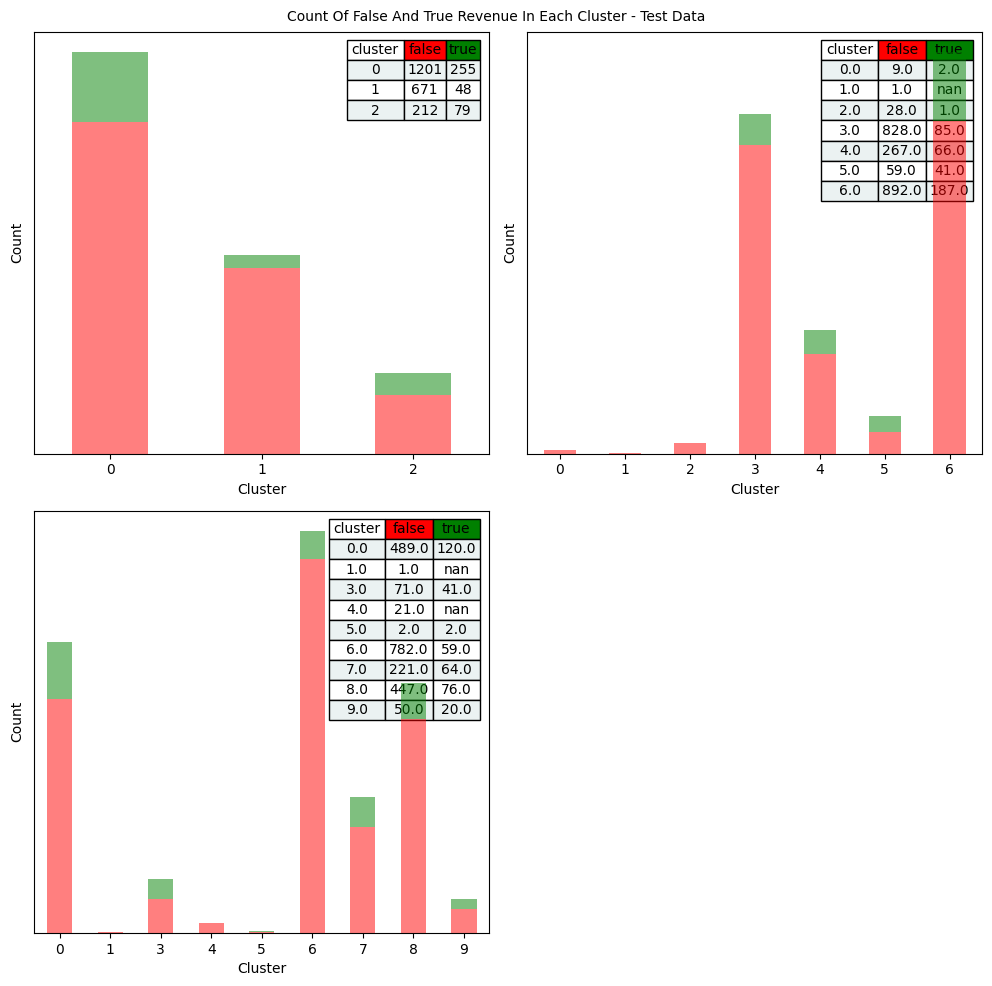

In [38]:
#preparing data
cats_tst = [df_x_tst.columns.get_loc(col) for col in df_x_tst.columns if df_x_tst[col].dtype=="category"]
cols = ['cluster','false','true']
df_tmp = []
for m in best_models:
    df_stk = pd.DataFrame({'cluster': m.predict(df_x_tst.to_numpy(),cats_tst).tolist(), 
                           'revenue':df_y_tst['Revenue'].tolist()})
    df_stk = df_stk.groupby('cluster')['revenue'].value_counts().rename('count').to_frame().unstack().reset_index()
    df_stk.columns = df_stk.columns.to_flat_index()
    cols_dict = {df_stk.columns[i]:cols[i] for i in range(len(cols))}
    df_stk = df_stk.rename(columns=cols_dict)
    df_tmp.append(df_stk)

#plotting
ttl='Count of false and true Revenue in each cluster - Test Data'
plot_bar_table(df_tmp, title=ttl, filename='fig_21.png',show=show)

C:\Users\hanis\.conda\envs\MLDL\lib\site-packages\umap\umap_.py:1880: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


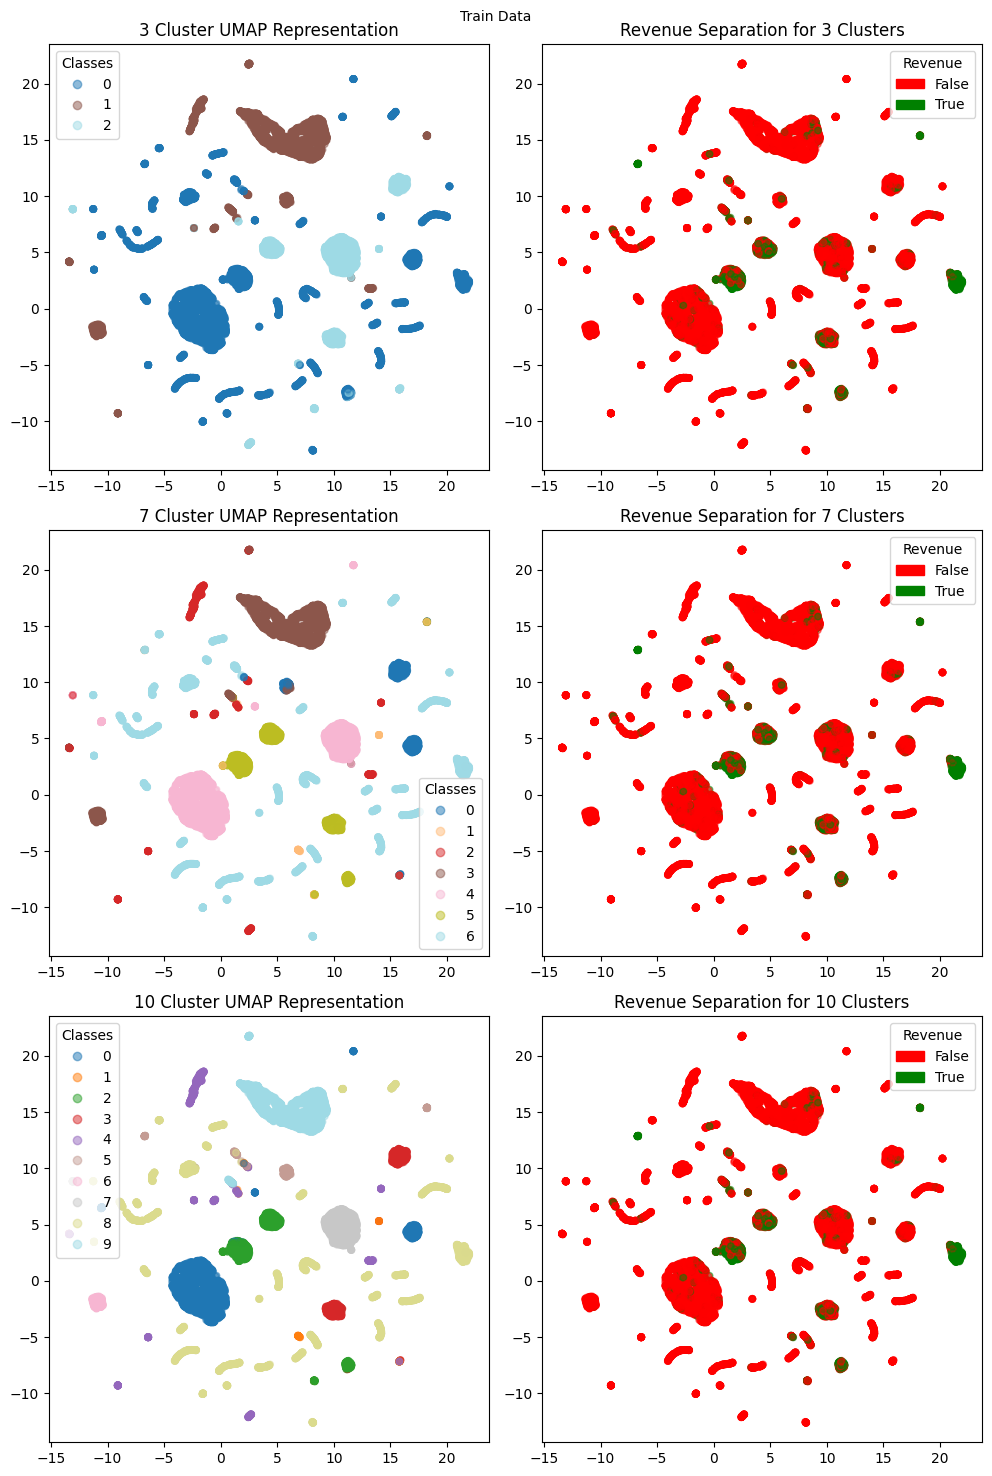

In [39]:
#preparing data
embed_dif_trn = UMAP_different_metrics(df_x_trn)

#plotting
UMAP_Plot(best_models, embed_dif_trn, df_x_trn, df_y_trn, mode='train', filename='fig_22.png', show=show)

C:\Users\hanis\.conda\envs\MLDL\lib\site-packages\umap\umap_.py:1880: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


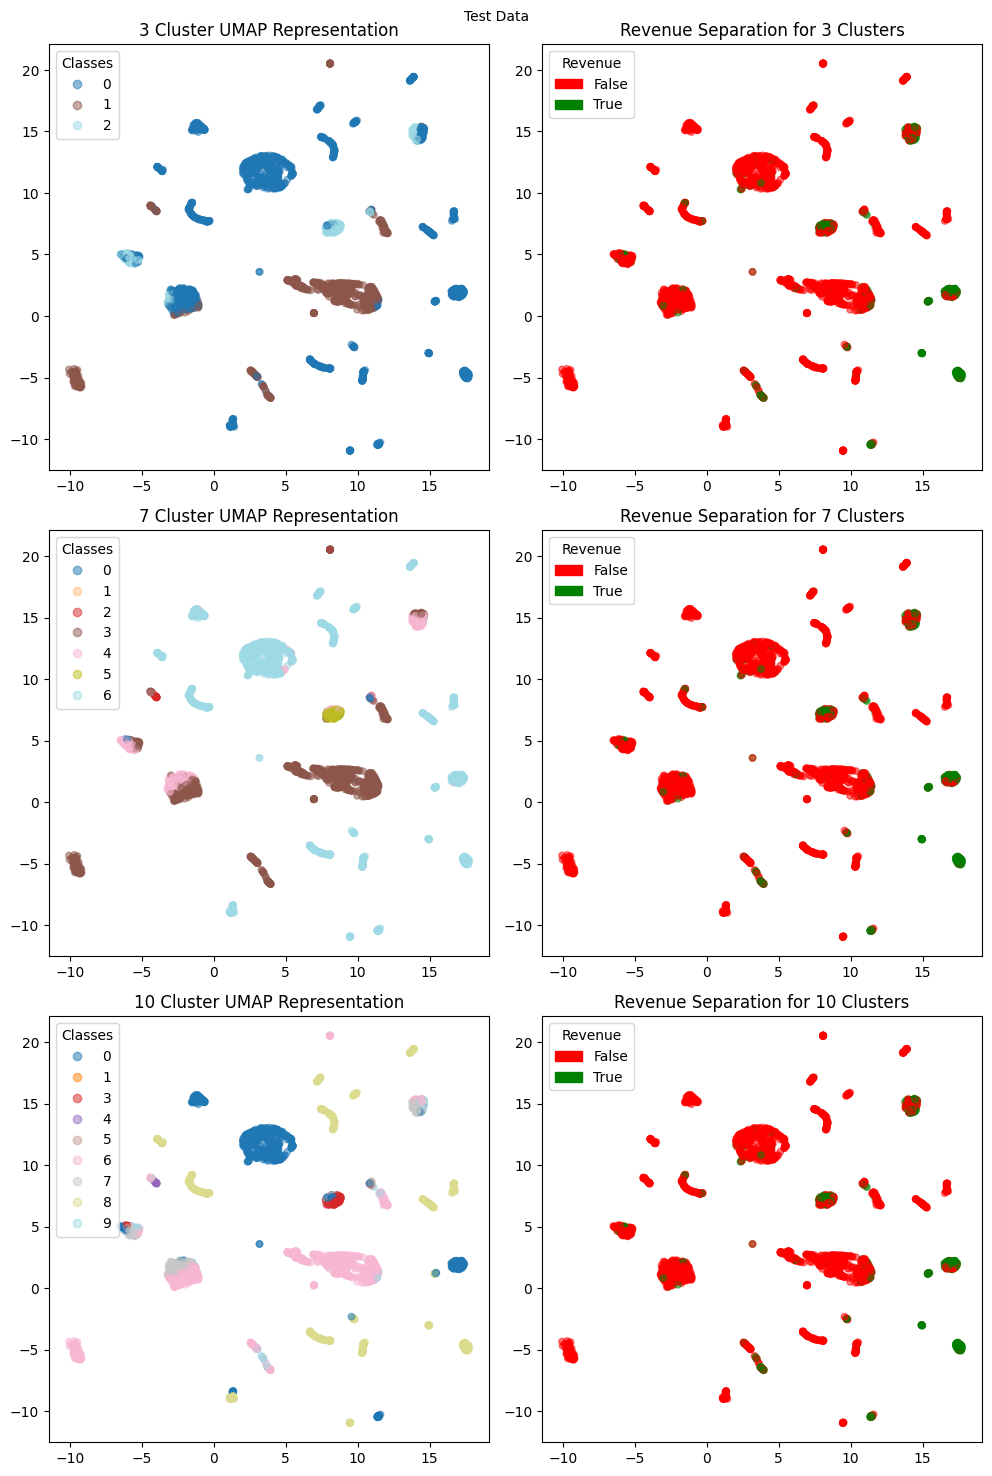

In [40]:
#preparing data
embed_dif_tst = UMAP_different_metrics(df_x_tst)

#plotting
UMAP_Plot(best_models, embed_dif_tst, df_x_tst, df_y_tst, mode='test', filename='fig_23.png', show=show)

C:\Users\hanis\.conda\envs\MLDL\lib\site-packages\umap\umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


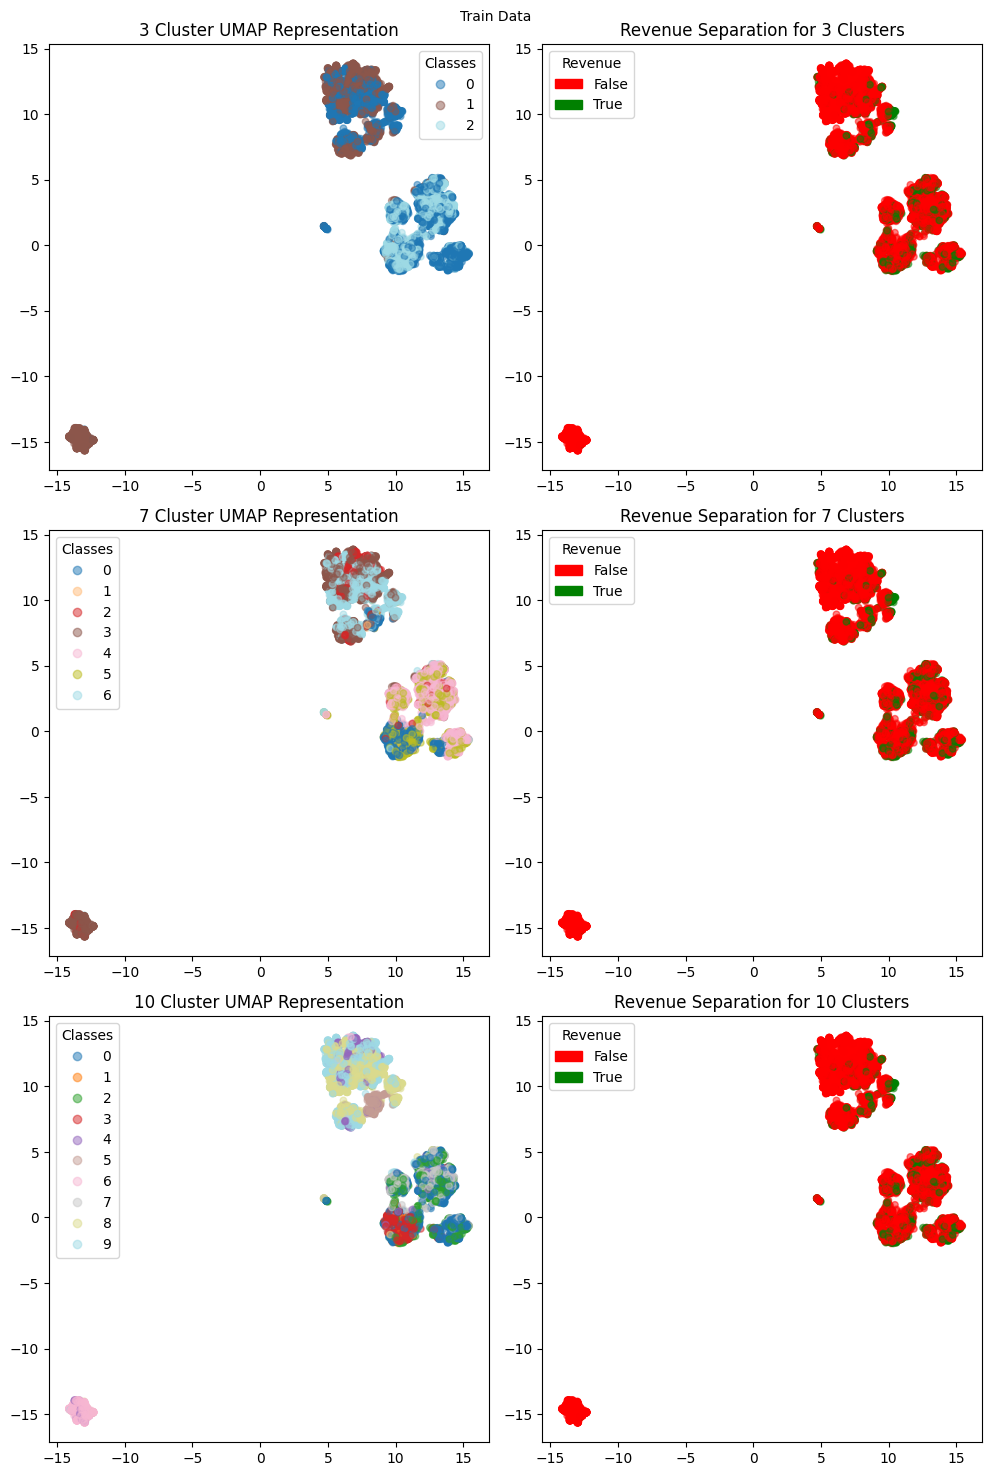

In [41]:
#preparing data
embed_gwr_trn = UMAP_Gower_metric(df_x_trn)

#plotting
UMAP_Plot(best_models, embed_gwr_trn, df_x_trn, df_y_trn, mode='train', filename='fig_24.png', show=show)

C:\Users\hanis\.conda\envs\MLDL\lib\site-packages\umap\umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


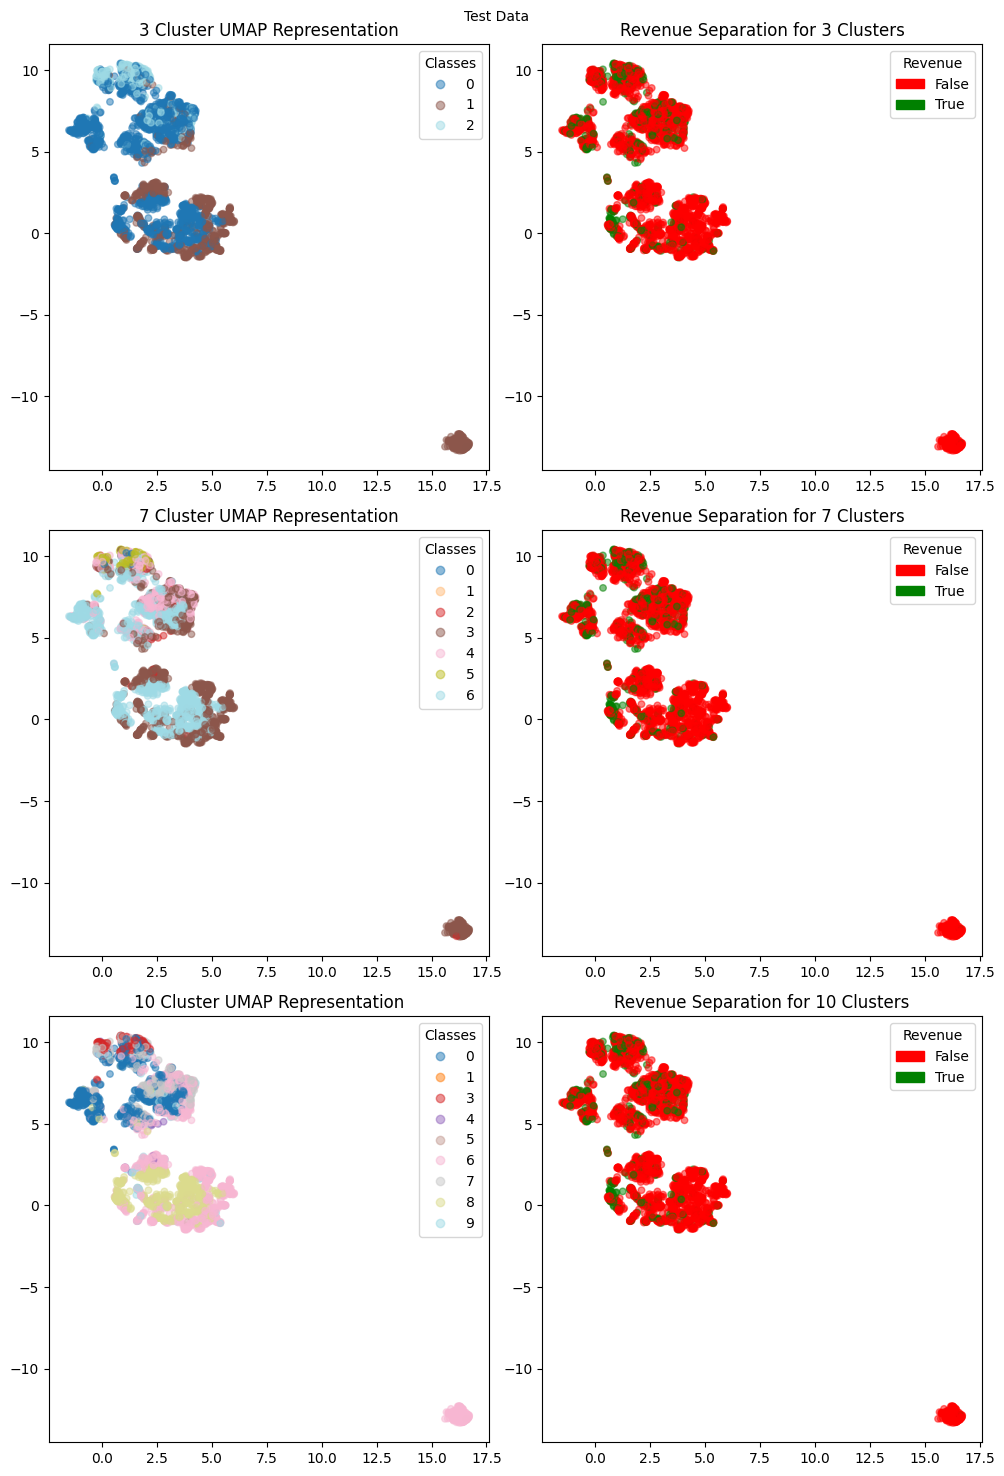

In [42]:
#preparing data
embed_gwr_tst = UMAP_Gower_metric(df_x_tst)

#plotting
UMAP_Plot(best_models, embed_gwr_tst, df_x_tst, df_y_tst, mode='test', filename='fig_25.png', show=show)